In [ ]:
"""
1)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import integrate
from matplotlib.colors import ListedColormap

import matplotlib.cm as cm
import matplotlib.colors as colors

# Data and parameters
data = {
    'Year': [1895, 1900, 1910, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 1995, 2000, 2005, 2010, 2020],
    'Spanish': [3394259.0, 4054539.0, 10907376.0, 11624643.0, 14080954.0, 19272593.0, 25968301.0, 36946313.0, 51353211.0, 64104668.0, 74378670.0, 78381411.0, 83704299.0, 93203961.0, 108408500.0],
    'Indigenous': [1030670.0, 1144766.0, 1619825.0, 2370324.0, 2490909.0, 2447615.0, 3030254.0, 3111415.0, 5181038.0, 5282347.0, 5483555.0, 6044547.0, 6011202.0, 6695228.0, 7177185.0],
    'Bilingual': [297977.0, 337528.0, 478232.0, 1126925.0, 1253891.0, 1652544.0, 1925299.0, 2251561.0, 3932514.0, 4411818.0, 4671553.0, 5022373.0, 5274418.0, 5676791.0, 6383553.0]
}
df = pd.DataFrame(data)

# Define logistic function
def logistic_function(t, K, r, N0):
    """
    Logistic growth function
    
    Parameters:
    t (array-like): Time points
    K (float): Carrying capacity
    r (float): Growth rate
    N0 (float): Initial value
    
    Returns:
    array-like: values
    """
    return K / (1 + ((K - N0) / N0) * np.exp(-r * t))

# Parameters provided
# For Bilingual
N0_bilingual = 272030  # Initial value
K_bilingual = 8615939  # Carrying capacity
r_bilingual = 0.036    # Growth rate

# For Indigenous
N0_indigenous = 1012848  # Initial value
K_indigenous = 12918933  # Carrying capacity
r_indigenous = 0.022     # Growth rate

# For Spanish
N0_spanish = 3117878    # Initial value
K_spanish = 165995301   # Carrying capacity
r_spanish = 0.037       # Growth rate

# Convert years to time points starting from 0 (1895 = 0)
base_year = 1895
df['t'] = df['Year'] - base_year

# Parameters for p_o function
A = 5.47
nu = 0.271
p_max = 0.97

# Parameters for dynamics f function
s_o = 0.0349  # Status of Bilingual language (adjust as needed)
s_l = 0.0055  # Status of Indigenous language (adjust as needed)
a = 1.2591     # Preference parameter (adjust as needed)

"""# Parameters for dynamics f function
s_o = 0.047  # Status of Bilingual language (adjust as needed)
s_l = 0.015  # Status of Indigenous language (adjust as needed)
a = 0.6553     # Preference parameter (adjust as needed)
"""
# params to extract points of I and S around t_fixed
delta_factor=0.05 # 5% 
num_points=5 # five points

# Create time points for smooth curves
t_smooth = np.linspace(0, 2020-base_year, 500)

def logistic_function(t, K, r, N0):
    """
    Logistic growth function
    
    Parameters:
    t (array-like): Time points
    K (float): Carrying capacity
    r (float): Growth rate
    N0 (float): Initial value
    
    Returns:
    array-like: values
    """
    return K / (1 + ((K - N0) / N0) * np.exp(-r * t))

# Function to calculate m_si (ratio of Spanish to Indigenous speakers)
def m_si(t, S=None, I=None):
    """
    Calculate the ratio of Spanish speakers to Indigenous speakers
    
    Parameters:
    t (float or array): Time points
    S (float or array, optional): Number of Spanish speakers. If None, calculated from logistic function
    I (float or array, optional): Number of Indigenous speakers. If None, calculated from logistic function
    If S and I are not None, pass t as None or any value
    
    Returns:
    float or array: Ratio S/I
    """
    if S is None:
        S = logistic_function(t, K_spanish, r_spanish, N0_spanish)
    if I is None:
        I = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
    
    # Avoid division by zero
    ratio = np.where(I > 0, S / I, np.inf)
    return ratio
# Function to find fixed points at a given time t

# Standard dynamics term f(x_o)
def f(x_o, s_o=s_o, s_l=s_l, a=a):
    return s_o * (x_o**a) * (1 - x_o) - s_l * ((1 - x_o)**a) * x_o

# Dynamics for natural increments
def g(x_o,p_o,m,I):
    """
    g(x_o, I) = [p_o - x_o - p_o * (1 - \frac{p_o}{p_{max}})*nu*m_{si} ] * r_I *(1 - \frac{I}{K_I})
    """
    
    term_1=p_o - x_o -p_o*(1-p_o/p_max)*nu*m
    term_2=r_indigenous*(1-I/K_indigenous)
    g=term_1*term_2
    return g

# Function for p_o given m_si
def p_o(m, p_max=p_max, A=A, nu=nu):
    return p_max / (1 + A * np.exp(-nu * m))

def find_fixed_points(t, I_values):
    fixed_points = []
    

    # Compute S(t) from logistic function
    S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
    
    # Define a small range around I_t
    delta_S = delta_factor * S_t  # Define range as a fraction of I_t
    S_values = np.linspace(S_t - delta_S, S_t + delta_S, num_points)
    
    for j,I in enumerate(I_values):
        if I > 0:  # Avoid division by zero
            # step 1 calculate the S corresponding to I
            S=S_values[j]
                        
            m = m_si(None,S,I)
            p = p_o(m)
            
        
            
            # Define equation for fixed point
            def fixed_point_eq(x_o):
                return f(x_o) + g(x_o,p,m,I)
            
            # Try multiple initial guesses
            initial_guesses = [0.50,0.9,0.95,0.99]
            for guess in initial_guesses:
                try:
                    sol = fsolve(fixed_point_eq, guess, full_output=True)
                    if sol[2] == 1:  # Check if fsolve converged
                        x_o = sol[0][0]
                        if 0 <= x_o <= 1:  # Check if solution is in valid range
                            fixed_points.append((x_o, I,S,p))
                except:
                    continue
    
    # Remove duplicates (with some tolerance)
    unique_points = []
    for point in fixed_points:
        is_duplicate = False
        for unique in unique_points:
            if np.abs(point[0] - unique[0]) < 1e-6 and np.abs(point[1] - unique[1]) < 1e-6:
                is_duplicate = True
                break
        if not is_duplicate:
            unique_points.append(point)
            
    return unique_points

# Function to analyze stability
def analyze_stability(fixed_points, t):
    results = []
    for x_o, I,S,p in fixed_points:
        J = calculate_jacobian(x_o, I, S,p)
        eigenvalues = np.linalg.eigvals(J)
        stable = all(np.real(eigenvalues) < 0)
        det_J = np.linalg.det(J)

        
        results.append((x_o, I, S,p,stable, eigenvalues))
    return results

def calculate_jacobian(x_o, I, S,p):
    """
    J_{00} =A_{00}+B_{00}+C_{00} J_00 DOES NOT DEPEND ON P AND M

\begin{equation}
    \label{eq:jacobian_00}
    \begin{cases}
    
    A_{00}=\left(1-2x_o\right)\left[s_o x_o^{a-1} - s_l(1-x_o)^{a-1}\right]\\
    B_{00}=x_o\left(1-x_o\right)\left[(a-1)(s_o x_o^{a-2} + s_l(1-x_o)^{a-2})\right] \\
    C_{00}=-r_I \left(1 - \frac{I}{K_I} \right)\\
    \end{cases}
\end{equation}
    """
    
    """
    $J_{01} =A_{01}+B_{01}$ DEPENDS ON P AND S
\begin{equation}
    \label{eq:jacobian_01}
    \begin{cases}
    A_{01}=-\left[p_o\left(1-\nu\frac{S}{I}\right) +\frac{\nu}{p_{max}}\frac{S}{I}p_o^2- x_o\right]\cdot \frac{r_I}{K_I}\\
    B_{01}=r_I\left(1-\frac{I}{K_I}\right)\cdot \nu^2\frac{S^2}{I^3}p_o\left(1-\frac{p_o}{p_{max}}\right)\left(1-2\frac{p_o}{p_{max}}\right)
    \end{cases}
\end{equation}

    """
    # J_00
    A_00=(1-2*x_o)*(s_o*x_o**(a-1) - s_l*(1-x_o)*(a-1))
    B_00=x_o*(1-x_o)*((a-1)*(s_o*x_o**(a-2) + s_l*(1-x_o)**(a-2)))
    C_00= -r_indigenous*(1-I/K_indigenous)
    J_00=A_00+B_00+C_00

    #J_10
    J_10 = 0  # x_o doesn't affect I
    
    # J_01
    h=(p*(1- nu*(S/I)) +(nu/p_max)*(S/I)*p**2- x_o)
    A_01=-h*(r_indigenous/K_indigenous)
    B_01=r_indigenous*(1-(I/K_indigenous))* nu**2 *(S**2/I**3)*p*(1-(p/p_max))*(1-2*(p/p_max))
    J_01=A_01+B_01
    
    # J_11
    J_11=r_indigenous*(1-2*(I/K_indigenous))

    return np.array([[J_00, J_01], [J_10, J_11]])

def system(t, state,S,p):
    """
    \begin{equation*}
    \begin{cases}
        (i)\quad \frac{dx_o}{dt} &= s_o x_o^a (1 - x_o) - s_l (1 - x_o)^a x_o +\left[p_o - x_o - p_o \left(1 - \frac{p_o}{p_{max}}\right) \nu m_{si} \right]r_I \left(1 - \frac{I}{K_I} \right), \\[10pt]
        (ii)\quad \frac{dI}{dt} &= r_I I \left(1 - \frac{I}{K_I} \right), \\[10pt]
    \end{cases}
\end{equation*}

    """
    x_o, I = state
    
    m = m_si(t,S,I)
    term_1=s_o*x_o**a*(1 - x_o) - s_l*(1 - x_o)**a*x_o
    term_2=p- x_o - p *(1 - (p/p_max)) *nu * m
    term_3=r_indigenous*(1 - (I/K_indigenous))
    
    dI_dt = r_indigenous * I* (1-(I/K_indigenous))
    dx_o_dt = term_1+term_2*term_3
    
    return [dx_o_dt, dI_dt]
    
# Function to visualize vector field and fixed points
def plot_vector_field_old(t, x_range, I_range, S,p,fixed_points_with_stability):
    X, I = np.meshgrid(x_range, I_range)
    U = np.zeros(X.shape)
    V = np.zeros(X.shape)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x_o, I_val = X[i,j], I[i,j]
            if I_val > 0:  # Avoid division by zero
                state = [x_o, I_val]
                derivatives = system(t, state,S,p)
                U[i,j], V[i,j] = derivatives
    
    # Normalize vectors for better visualization
    magnitude = np.sqrt(U**2 + V**2)
    max_mag = np.percentile(magnitude[magnitude > 0], 95)  # Use 95th percentile to avoid outliers
    U = U / max_mag
    V = V / max_mag
    
    plt.figure(figsize=(10, 8))
    plt.streamplot(X, I, U, V, density=1, color='gray', linewidth=0.5)
    
    # Plot fixed points
    stable_points = [(x, I) for x, I, S,p,stable, _ in fixed_points_with_stability if stable]
    unstable_points = [(x, I) for x, I, S,p,stable, _ in fixed_points_with_stability if not stable]
    
    if stable_points:
        stable_x, stable_I = zip(*stable_points)
        plt.scatter(stable_x, stable_I, color='green', s=100, label='Stable Fixed Points')
    
    if unstable_points:
        unstable_x, unstable_I = zip(*unstable_points)
        plt.scatter(unstable_x, unstable_I, color='red', s=100, label='Unstable Fixed Points')
    
    plt.xlabel('$x_o$')
    plt.ylabel('$I$')
    plt.title(f'Vector Field and Fixed Points at t = {t}')
    plt.xlim(min(x_range), max(x_range))
    plt.ylim(min(I_range), max(I_range))
    plt.grid(True)
    plt.legend()
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='Vector Magnitude')
    
    return plt.gcf()

def plot_vector_field(t, x_range, I_range, S, p, fixed_points_with_stability):
    X, I = np.meshgrid(x_range, I_range)
    U = np.zeros(X.shape)
    V = np.zeros(X.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x_o, I_val = X[i, j], I[i, j]
            if I_val > 0:  # Avoid division by zero
                state = [x_o, I_val]
                derivatives = system(t, state, S, p)
                U[i, j], V[i, j] = derivatives

    # Compute magnitude for color mapping
    magnitude = np.sqrt(U**2 + V**2)
    max_mag = np.percentile(magnitude[magnitude > 0], 95)
    U = U / max_mag
    V = V / max_mag

    fig, ax = plt.subplots(figsize=(10, 8))
    stream = ax.streamplot(X, I, U, V, density=1, color=magnitude, cmap='viridis', linewidth=0.5)

    # Plot fixed points
    stable_points = [(x, I) for x, I, S, p, stable, _ in fixed_points_with_stability if stable]
    unstable_points = [(x, I) for x, I, S, p, stable, _ in fixed_points_with_stability if not stable]

    if stable_points:
        stable_x, stable_I = zip(*stable_points)
        ax.scatter(stable_x, stable_I, color='green', s=100, label='Stable Fixed Points')

    if unstable_points:
        unstable_x, unstable_I = zip(*unstable_points)
        ax.scatter(unstable_x, unstable_I, color='red', s=100, label='Unstable Fixed Points')

    ax.set_xlabel('$x_o$')
    ax.set_ylabel('$I$')
    ax.set_title(f'Vector Field and Fixed Points at t = {t}')
    ax.set_xlim(min(x_range), max(x_range))
    ax.set_ylim(min(I_range), max(I_range))
    ax.grid(True)
    ax.legend()

    # ✅ Correct colorbar handling
    norm = colors.Normalize(vmin=magnitude.min(), vmax=magnitude.max())
    sm = cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Required for colorbar
    cbar = fig.colorbar(sm, ax=ax, label='Vector Magnitude')

    return fig

    
def analyze_system(time_points):
    all_results = {}
    x_range = np.linspace(0.01, 0.99, 30)
    I_range=logistic_function(t_smooth, K_indigenous, r_indigenous, N0_indigenous)

    I_range = np.linspace(I_range[0], I_range[-1], 30)
    
  
    
    for t in time_points:
        # Compute I(t) from logistic function
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        
        # Define a small range around I_t
        delta_I = delta_factor * I_t  # Define range as a fraction of I_t
        I_values = np.linspace(I_t - delta_I, I_t + delta_I, num_points)
        I_range = np.linspace(I_values[0], I_values[-1], 30)
        print(f"Analyzing at time t = {t} and I_values = {I_values}")
        fixed_points = find_fixed_points(t,I_values)
        stability_results = analyze_stability(fixed_points, t)
        print(f"Found {len(fixed_points)} fixed points at t = {t}")
        for i, (x_o, I, S,p,stable, eigenvalues) in enumerate(stability_results):
            stability = "Stable" if stable else "Unstable"
            print(f"  Fixed Point {i+1}: (x_o = {x_o:.4f}, I = {I:.4f}) - {stability}, S = {S:.4f}, p = {p}")
            print(f"    Eigenvalues: {eigenvalues}")
    
            fig = plot_vector_field(t, x_range, I_range, S,p, stability_results)
            all_results[t] = {
                'fixed_points': fixed_points,
                'stability': stability_results,
                'figure': fig
            }
    
    return all_results

def main():
    # Define analysis parameters
    time_points = [10.0, 20.0, 30.0, 40.0,100.0]

   
    analyze_system(time_points)
    
    
if __name__ == "__main__":
    main()
    
    """
    I NEED THAT FOR A GIVEN T 5 VALUES OF I ARE CALCULAYED WITH LOGISTIC, THEN 5 S. 5 P AND 5 M.
    THEN PLOT VECTOR FIELDS
    BUT THE fig = plot_vector_field(t, x_range, I_range, S,p, stability_results) IN THE LOOPS (NECAUSE I NEED P AND M FOR EACH T) PLOTS TOO MUCH PLOTS
    """

In [ ]:
"""
2)
"""


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.colors as colors

# Data and parameters
data = {
    'Year': [1895, 1900, 1910, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 1995, 2000, 2005, 2010, 2020],
    'Spanish': [3394259.0, 4054539.0, 10907376.0, 11624643.0, 14080954.0, 19272593.0, 25968301.0, 36946313.0, 51353211.0, 64104668.0, 74378670.0, 78381411.0, 83704299.0, 93203961.0, 108408500.0],
    'Indigenous': [1030670.0, 1144766.0, 1619825.0, 2370324.0, 2490909.0, 2447615.0, 3030254.0, 3111415.0, 5181038.0, 5282347.0, 5483555.0, 6044547.0, 6011202.0, 6695228.0, 7177185.0],
    'Bilingual': [297977.0, 337528.0, 478232.0, 1126925.0, 1253891.0, 1652544.0, 1925299.0, 2251561.0, 3932514.0, 4411818.0, 4671553.0, 5022373.0, 5274418.0, 5676791.0, 6383553.0]
}
df = pd.DataFrame(data)

# Convert years to time points starting from 0 (1895 = 0)
base_year = 1895
df['t'] = df['Year'] - base_year

# Parameters for logistic functions
# For Bilingual
N0_bilingual = 272030  # Initial value
K_bilingual = 8615939  # Carrying capacity
r_bilingual = 0.036    # Growth rate

# For Indigenous
N0_indigenous = 1012848  # Initial value
K_indigenous = 12918933  # Carrying capacity
r_indigenous = 0.022     # Growth rate

# For Spanish
N0_spanish = 3117878    # Initial value
K_spanish = 165995301   # Carrying capacity
r_spanish = 0.037       # Growth rate

# Parameters for p_o function
A = 5.47
nu = 0.271
p_max = 0.97

# Parameters for dynamics f function
s_o = 0.0349  # Status of Bilingual language
s_l = 0.0055  # Status of Indigenous language
a = 1.2591    # Preference parameter

# Parameters for dynamics f function
s_o = 0.047  # Status of Bilingual language (adjust as needed)
s_l = 0.015  # Status of Indigenous language (adjust as needed)
a = 0.6553     # Preference parameter (adjust as needed)


# Parameters to extract points of I and S around t_fixed
delta_factor = 0.05  # 5%
num_points = 5  # five points

# Create time points for smooth curves
t_smooth = np.linspace(0, 2020-base_year, 500)

def logistic_function(t, K, r, N0):
    """
    Logistic growth function
    
    Parameters:
    t (array-like): Time points
    K (float): Carrying capacity
    r (float): Growth rate
    N0 (float): Initial value
    
    Returns:
    array-like: Population values at time t
    """
    return K / (1 + ((K - N0) / N0) * np.exp(-r * t))

def m_si(t=None, S=None, I=None):
    """
    Calculate the ratio of Spanish speakers to Indigenous speakers
    
    Parameters:
    t (float or array, optional): Time points
    S (float or array, optional): Number of Spanish speakers. If None, calculated from logistic function
    I (float or array, optional): Number of Indigenous speakers. If None, calculated from logistic function
    
    Returns:
    float or array: Ratio S/I
    """
    if S is None and t is not None:
        S = logistic_function(t, K_spanish, r_spanish, N0_spanish)
    if I is None and t is not None:
        I = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
    
    # Avoid division by zero
    ratio = np.where(I > 0, S / I, np.inf)
    return ratio

def p_o(m, p_max=p_max, A=A, nu=nu):
    """
    Calculate p_o given m_si
    
    Parameters:
    m (float or array): m_si ratio
    p_max (float): Maximum value for p_o
    A (float): Scaling parameter
    nu (float): Growth parameter
    
    Returns:
    float or array: p_o value(s)
    """
    return p_max / (1 + A * np.exp(-nu * m))

def f(x_o, s_o=s_o, s_l=s_l, a=a):
    """
    Standard dynamics term f(x_o)
    
    Parameters:
    x_o (float): Proportion of bilingual speakers
    s_o (float): Status of bilingual language
    s_l (float): Status of indigenous language
    a (float): Preference parameter
    
    Returns:
    float: Dynamics value
    """
    return s_o * (x_o**a) * (1 - x_o) - s_l * ((1 - x_o)**a) * x_o

def g(x_o, p_o, m, I):
    """
    Dynamics for natural increments
    
    Parameters:
    x_o (float): Proportion of bilingual speakers
    p_o (float): Probability parameter
    m (float): m_si ratio
    I (float): Indigenous population
    
    Returns:
    float: g function value
    """
    term_1 = p_o - x_o - p_o * (1 - p_o/p_max) * nu * m
    term_2 = r_indigenous * (1 - I/K_indigenous)
    return term_1 * term_2

def find_fixed_points(t):
    """
    Find fixed points in the system at time t
    
    Parameters:
    t (float): Time point
    
    Returns:
    list: List of fixed points (x_o, I, S, p)
    """
    fixed_points = []
    
    # Compute I(t) from logistic function
    I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
    S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
    
    # Define ranges around I_t and S_t
    delta_I = delta_factor * I_t
    delta_S = delta_factor * S_t
    I_values = np.linspace(I_t - delta_I, I_t + delta_I, num_points)
    S_values = np.linspace(S_t - delta_S, S_t + delta_S, num_points)
    
    for i, I in enumerate(I_values):
        if I <= 0:  # Skip non-positive values
            continue
            
        for j, S in enumerate(S_values):
            m = m_si(None, S, I)
            p = p_o(m)
            
            # Define equation for fixed point
            def fixed_point_eq(x_o):
                return f(x_o) + g(x_o, p, m, I)
            
            # Try multiple initial guesses
            initial_guesses = [0.50, 0.9, 0.95, 0.99]
            for guess in initial_guesses:
                try:
                    sol = fsolve(fixed_point_eq, guess, full_output=True)
                    if sol[2] == 1:  # Check if fsolve converged
                        x_o = sol[0][0]
                        if 0 <= x_o <= 1:  # Check if solution is in valid range
                            fixed_points.append((x_o, I, S, p))
                except Exception as e:
                    print(f"Error in fsolve: {e}")
                    continue
    
    # Remove duplicates (with some tolerance)
    unique_points = []
    for point in fixed_points:
        is_duplicate = False
        for unique in unique_points:
            if np.abs(point[0] - unique[0]) < 1e-6 and np.abs(point[1] - unique[1]) < 1e-6:
                is_duplicate = True
                break
        if not is_duplicate:
            unique_points.append(point)
            
    return unique_points

def calculate_jacobian(x_o, I, S, p):
    """
    Calculate the Jacobian matrix at a fixed point
    
    Parameters:
    x_o (float): Fixed point x_o value
    I (float): Fixed point I value
    S (float): S value at fixed point
    p (float): p value at fixed point
    
    Returns:
    numpy.ndarray: 2x2 Jacobian matrix
    """
    try:
        # J_00 components
        A_00 = (1-2*x_o) * (s_o * x_o**(a-1) - s_l * (1-x_o)**(a-1))
        B_00 = x_o * (1-x_o) * ((a-1) * (s_o * x_o**(a-2) + s_l * (1-x_o)**(a-2)))
        C_00 = -r_indigenous * (1 - I/K_indigenous)
        J_00 = A_00 + B_00 + C_00

        # J_10 component
        J_10 = 0  # x_o doesn't affect I
        
        # J_01 components
        h = (p * (1 - nu * (S/I)) + (nu/p_max) * (S/I) * p**2 - x_o)
        A_01 = -h * (r_indigenous/K_indigenous)
        B_01 = r_indigenous * (1 - (I/K_indigenous)) * nu**2 * (S**2/I**3) * p * (1 - (p/p_max)) * (1 - 2 * (p/p_max))
        J_01 = A_01 + B_01
        
        # J_11 component
        J_11 = r_indigenous * (1 - 2 * (I/K_indigenous))

        return np.array([[J_00, J_01], [J_10, J_11]])
    except Exception as e:
        print(f"Error calculating Jacobian: {e}")
        # Return a default Jacobian with very large eigenvalues to make point unstable
        return np.array([[100.0, 0.0], [0.0, 100.0]])

def analyze_stability(fixed_points):
    """
    Analyze the stability of fixed points
    
    Parameters:
    fixed_points (list): List of fixed points (x_o, I, S, p)
    
    Returns:
    list: List of fixed points with stability information
    """
    results = []
    for x_o, I, S, p in fixed_points:
        try:
            J = calculate_jacobian(x_o, I, S, p)
            eigenvalues = np.linalg.eigvals(J)
            stable = all(np.real(eigenvalues) < 0)
            results.append((x_o, I, S, p, stable, eigenvalues))
        except Exception as e:
            print(f"Error in stability analysis: {e}")
            # Mark as unstable by default
            results.append((x_o, I, S, p, False, np.array([1.0, 1.0])))
    
    return results

def system(t, state, S, p):
    """
    System of differential equations
    
    Parameters:
    t (float): Time
    state (list): [x_o, I]
    S (float): Spanish speakers
    p (float): Probability parameter
    
    Returns:
    list: [dx_o/dt, dI/dt]
    """
    x_o, I = state
    
    if I <= 0:  # Avoid division by zero
        return [0, 0]
    
    m = m_si(None, S, I)
    
    # dx_o/dt calculation
    term_1 = s_o * x_o**a * (1 - x_o) - s_l * (1 - x_o)**a * x_o
    term_2 = p - x_o - p * (1 - (p/p_max)) * nu * m
    term_3 = r_indigenous * (1 - (I/K_indigenous))
    dx_o_dt = term_1 + term_2 * term_3
    
    # dI/dt calculation
    dI_dt = r_indigenous * I * (1 - (I/K_indigenous))
    
    return [dx_o_dt, dI_dt]

def plot_vector_field(t, x_range, I_range, S, p, fixed_points_with_stability):
    """
    Plot vector field and fixed points
    
    Parameters:
    t (float): Time
    x_range (array): Range of x_o values
    I_range (array): Range of I values
    S (float): Spanish speakers at time t
    p (float): Probability parameter at time t
    fixed_points_with_stability (list): Fixed points with stability information
    
    Returns:
    matplotlib.figure.Figure: Figure object
    """
    X, I = np.meshgrid(x_range, I_range)
    U = np.zeros(X.shape)
    V = np.zeros(X.shape)
    
    # Vectorized calculation - much faster!
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if I[i, j] > 0:
                derivatives = system(t, [X[i, j], I[i, j]], S, p)
                U[i, j], V[i, j] = derivatives

    # Compute magnitude for color mapping
    magnitude = np.sqrt(U**2 + V**2)
    # Avoid division by zero
    max_mag = np.percentile(magnitude[magnitude > 0], 95) if np.any(magnitude > 0) else 1.0
    U_norm = np.where(magnitude > 0, U / max_mag, 0)
    V_norm = np.where(magnitude > 0, V / max_mag, 0)

    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use streamplot with normalized vectors
    stream = ax.streamplot(X, I, U_norm, V_norm, density=1, color=magnitude, cmap='viridis', linewidth=0.5)

    # Plot fixed points
    stable_points = [(x, I) for x, I, _, _, stable, _ in fixed_points_with_stability if stable]
    unstable_points = [(x, I) for x, I, _, _, stable, _ in fixed_points_with_stability if not stable]

    if stable_points:
        stable_x, stable_I = zip(*stable_points)
        ax.scatter(stable_x, stable_I, color='green', s=100, label='Stable Fixed Points')

    if unstable_points:
        unstable_x, unstable_I = zip(*unstable_points)
        ax.scatter(unstable_x, unstable_I, color='red', s=100, label='Unstable Fixed Points')

    ax.set_xlabel('$x_o$ (Proportion of Bilingual Speakers)')
    ax.set_ylabel('$I$ (Indigenous Population)')
    ax.set_title(f'Vector Field and Fixed Points at t = {t} (Year {base_year + t})')
    ax.set_xlim(min(x_range), max(x_range))
    ax.set_ylim(min(I_range), max(I_range))
    ax.grid(True)
    ax.legend()

    # Correct colorbar handling
    norm = colors.Normalize(vmin=magnitude.min(), vmax=magnitude.max())
    sm = cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Required for colorbar
    cbar = fig.colorbar(sm, ax=ax, label='Vector Magnitude')

    plt.tight_layout()
    return fig

def analyze_system(time_points):
    """
    Analyze system dynamics at specified time points
    
    Parameters:
    time_points (list): List of time points to analyze
    
    Returns:
    dict: Dictionary of results for each time point
    """
    all_results = {}
    
    for t in time_points:
        print(f"\nAnalyzing at time t = {t} (Year {base_year + t})")
        
        # Calculate the expected values of I and S at time t
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        m_t = m_si(None, S_t, I_t)
        p_t = p_o(m_t)
        
        print(f"Expected values at t = {t}:")
        print(f"  I(t) = {I_t:.2f}, S(t) = {S_t:.2f}")
        print(f"  m_si = {m_t:.2f}, p_o = {p_t:.4f}")
        
        # Find fixed points
        fixed_points = find_fixed_points(t)
        print(f"Found {len(fixed_points)} fixed point(s) at t = {t}")
        
        # Analyze stability
        stability_results = analyze_stability(fixed_points)
        
        # Print fixed points and stability
        for i, (x_o, I, S, p, stable, eigenvalues) in enumerate(stability_results):
            stability = "Stable" if stable else "Unstable"
            print(f"  Fixed Point {i+1}: (x_o = {x_o:.4f}, I = {I:.4f}) - {stability}")
            print(f"    S = {S:.0f}, p = {p:.4f}")
            print(f"    Eigenvalues: {eigenvalues}")
        
        # Set up ranges for plotting
        x_range = np.linspace(0.01, 0.99, 30)
        
        # Use a reasonable range around the expected I_t
        I_min = max(0.1, I_t * 0.5)
        I_max = I_t * 1.5
        I_range = np.linspace(I_min, I_max, 30)
        
        # For each fixed point, create a vector field plot
        # We'll use the specific S and p values associated with each point
        # Using the representative values from expected trajectory
        fig = plot_vector_field(t, x_range, I_range, S_t, p_t, stability_results)
        
        all_results[t] = {
            'fixed_points': fixed_points,
            'stability': stability_results,
            'figure': fig,
            'I_t': I_t,
            'S_t': S_t,
            'm_t': m_t,
            'p_t': p_t
        }
    
    return all_results

def main():
    # Define analysis parameters - years since 1895
    time_points = [75.0, 85.0, 95.0, 105.0, 115.0]
    
    # Run the analysis
    results = analyze_system(time_points)
    
    # Save figures
    for t, result in results.items():
        result['figure'].savefig(f"vector_field_t{int(t)}.png", dpi=300, bbox_inches='tight')
    
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
"""
3) OK PER STABILITA'
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.metrics import mean_squared_error
# Data and parameters
data = {
    'Year': [1895, 1900, 1910, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 1995, 2000, 2005, 2010, 2020],
    'Spanish': [3394259.0, 4054539.0, 10907376.0, 11624643.0, 14080954.0, 19272593.0, 25968301.0, 36946313.0, 51353211.0, 64104668.0, 74378670.0, 78381411.0, 83704299.0, 93203961.0, 108408500.0],
    'Indigenous': [1030670.0, 1144766.0, 1619825.0, 2370324.0, 2490909.0, 2447615.0, 3030254.0, 3111415.0, 5181038.0, 5282347.0, 5483555.0, 6044547.0, 6011202.0, 6695228.0, 7177185.0],
    'Bilingual': [297977.0, 337528.0, 478232.0, 1126925.0, 1253891.0, 1652544.0, 1925299.0, 2251561.0, 3932514.0, 4411818.0, 4671553.0, 5022373.0, 5274418.0, 5676791.0, 6383553.0]
}
df = pd.DataFrame(data)

# Convert years to time points starting from 0 (1895 = 0)
base_year = 1895
df['t'] = df['Year'] - base_year

# Parameters for logistic functions
# For Bilingual
N0_bilingual = 272030  # Initial value
K_bilingual = 8615939  # Carrying capacity
r_bilingual = 0.036    # Growth rate

# For Indigenous
N0_indigenous = 1012848  # Initial value
K_indigenous = 12918933  # Carrying capacity
r_indigenous = 0.022     # Growth rate

# For Spanish
N0_spanish = 3117878    # Initial value
K_spanish = 165995301   # Carrying capacity
r_spanish = 0.037       # Growth rate

# Parameters for p_o function
A = 5.47
nu = 0.271
p_max = 0.97

# Parameters for dynamics f function
s_o = 0.0349  # Status of Bilingual language
s_l = 0.0055  # Status of Indigenous language
a = 1.252    # Preference parameter


# Parameters for dynamics f function
s_o = 0.047  # Status of Bilingual language (adjust as needed)
s_l = 0.015  # Status of Indigenous language (adjust as needed)
a = 0.6553     # Preference parameter (adjust as needed)
# Parameters to extract points of I and S around t_fixed
"""
# Parameters for dynamics f function
s_o = 0.0454  # Status of Bilingual language
s_l = 0.00838  # Status of Indigenous language
a = 1.4778    # Preference parameter
"""
delta_factor = 0.05  # 5%
num_points = 5  # five points

# Create time points for smooth curves
t_smooth = np.linspace(0, 2020-base_year, 500)

def logistic_function(t, K, r, N0):
    """
    Logistic growth function
    
    Parameters:
    t (array-like): Time points
    K (float): Carrying capacity
    r (float): Growth rate
    N0 (float): Initial value
    
    Returns:
    array-like: Population values at time t
    """
    return K / (1 + ((K - N0) / N0) * np.exp(-r * t))

def m_si(t=None, S=None, I=None):
    """
    Calculate the ratio of Spanish speakers to Indigenous speakers
    
    Parameters:
    t (float or array, optional): Time points
    S (float or array, optional): Number of Spanish speakers. If None, calculated from logistic function
    I (float or array, optional): Number of Indigenous speakers. If None, calculated from logistic function
    
    Returns:
    float or array: Ratio S/I
    """
    if S is None and t is not None:
        S = logistic_function(t, K_spanish, r_spanish, N0_spanish)
    if I is None and t is not None:
        I = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
    
    # Avoid division by zero
    if np.isscalar(I):
        return S / I if I > 0 else np.inf
    else:
        return np.where(I > 0, S / I, np.inf)

def p_o(m, p_max=p_max, A=A, nu=nu):
    """
    Calculate p_o given m_si
    
    Parameters:
    m (float or array): m_si ratio
    p_max (float): Maximum value for p_o
    A (float): Scaling parameter
    nu (float): Growth parameter
    
    Returns:
    float or array: p_o value(s)
    """
    return p_max / (1 + A * np.exp(-nu * m))

def f(x_o, s_o=s_o, s_l=s_l, a=a):
    """
    Standard dynamics term f(x_o)
    
    Parameters:
    x_o (float): Proportion of bilingual speakers
    s_o (float): Status of bilingual language
    s_l (float): Status of indigenous language
    a (float): Preference parameter
    
    Returns:
    float: Dynamics value
    """
    return s_o * (x_o**a) * (1 - x_o) - s_l * ((1 - x_o)**a) * x_o

def g(x_o, p_o, m, I):
    """
    Dynamics for natural increments
    
    Parameters:
    x_o (float): Proportion of bilingual speakers
    p_o (float): Probability parameter
    m (float): m_si ratio
    I (float): Indigenous population
    
    Returns:
    float: g function value
    """
    term_1 = p_o - x_o - p_o * (1 - p_o/p_max) * nu * m
    term_2 = r_indigenous * (1 - I/K_indigenous)
    return term_1 * term_2

def find_fixed_points(t):
    """
    Find fixed points in the system at time t
    
    Parameters:
    t (float): Time point
    
    Returns:
    list: List of fixed points (x_o, I, S, p)
    """
    fixed_points = []
    
    # Compute I(t) and S(t) from logistic function
    I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
    S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
    
    # Define ranges around I_t and S_t
    delta_I = delta_factor * I_t
    delta_S = delta_factor * S_t
    I_values = np.linspace(I_t - delta_I, I_t + delta_I, num_points)
    S_values = np.linspace(S_t - delta_S, S_t + delta_S, num_points)
    
    for i, I in enumerate(I_values):
        if I <= 0:  # Skip non-positive values
            continue
            
        for j, S in enumerate(S_values):
            m = m_si(None, S, I)
            p = p_o(m)
            
            # Define equation for fixed point
            def fixed_point_eq(x_o):
                return f(x_o) + g(x_o, p, m, I)
            
            # Try multiple initial guesses - IMPROVED to search near both 0 and 1
            initial_guesses = [0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
            for guess in initial_guesses:
                try:
                    sol = fsolve(fixed_point_eq, guess, full_output=True)
                    if sol[2] == 1:  # Check if fsolve converged
                        x_o = sol[0][0]
                        if 0 <= x_o <= 1:  # Check if solution is in valid range
                            fixed_points.append((x_o, I, S, p))
                except Exception as e:
                    print(f"Error in fsolve: {e}")
                    continue
    
    # Remove duplicates (with some tolerance)
    unique_points = []
    for point in fixed_points:
        is_duplicate = False
        for unique in unique_points:
            if np.abs(point[0] - unique[0]) < 1e-6 and np.abs(point[1] - unique[1]) < 1e-6:
                is_duplicate = True
                break
        if not is_duplicate:
            unique_points.append(point)
            
    return unique_points

def calculate_jacobian(x_o, I, S, p):
    """
    Calculate the Jacobian matrix at a fixed point - CORRECTED formulas for ASM model
    
    Parameters:
    x_o (float): Fixed point x_o value
    I (float): Fixed point I value
    S (float): S value at fixed point
    p (float): p value at fixed point
    
    Returns:
    numpy.ndarray: 2x2 Jacobian matrix
    """
    try:
        # Safe computations for powers
        def safe_pow(base, exponent):
            if base < 0 and not exponent.is_integer():
                return 0  # Avoid complex numbers
            if base == 0 and exponent < 0:
                return 0  # Avoid division by zero
            return base ** exponent
        
        # J_00 calculation - derivative of dx_o/dt with respect to x_o
        # Term from f(x_o)
        term1 = s_o * a * safe_pow(x_o, a-1) * (1-x_o) - s_o * safe_pow(x_o, a)
        term2 = -s_l * a * safe_pow(1-x_o, a-1) * x_o - s_l * safe_pow(1-x_o, a)
        
        # Term from g(x_o)
        term3 = -r_indigenous * (1 - I/K_indigenous)
        
        J_00 = term1 + term2 + term3
        
        # J_10 - derivative of dI/dt with respect to x_o
        J_10 = 0  # x_o doesn't affect I directly
        
        # J_01 - derivative of dx_o/dt with respect to I
        m = m_si(None, S, I)
        
        # Term from g(x_o)
        term4 = (p - x_o - p * (1 - p/p_max) * nu * m) * (-r_indigenous/K_indigenous)
        term5 = p * (1 - p/p_max) * nu * (-S/I**2) * r_indigenous * (1 - I/K_indigenous)
        
        J_01 = term4 + term5
        
        # J_11 - derivative of dI/dt with respect to I
        J_11 = r_indigenous * (1 - 2*I/K_indigenous)
        
        return np.array([[J_00, J_01], [J_10, J_11]])
    except Exception as e:
        print(f"Error calculating Jacobian: {e}")
        # Return a default Jacobian
        return np.array([[0.0, 0.0], [0.0, 0.0]])

def analyze_stability(fixed_points):
    """
    Analyze the stability of fixed points
    
    Parameters:
    fixed_points (list): List of fixed points (x_o, I, S, p)
    
    Returns:
    list: List of fixed points with stability information
    """
    results = []
    for x_o, I, S, p in fixed_points:
        try:
            J = calculate_jacobian(x_o, I, S, p)
            eigenvalues = np.linalg.eigvals(J)
            stable = all(np.real(eigenvalues) < 0)
            results.append((x_o, I, S, p, stable, eigenvalues))
        except Exception as e:
            print(f"Error in stability analysis: {e}")
            # Mark as unstable by default
            results.append((x_o, I, S, p, False, np.array([1.0, 1.0])))
    
    return results

def system(t, state, S, p):
    """
    System of differential equations
    
    Parameters:
    t (float): Time
    state (list): [x_o, I]
    S (float): Spanish speakers
    p (float): Probability parameter
    
    Returns:
    list: [dx_o/dt, dI/dt]
    """
    x_o, I = state
    
    if I <= 0:  # Avoid division by zero
        return [0, 0]
    
    m = m_si(None, S, I)
    
    # dx_o/dt calculation
    term_1 = f(x_o)  # Standard dynamics
    term_2 = g(x_o, p, m, I)  # Natural increments
    dx_o_dt = term_1 + term_2
    
    # dI/dt calculation
    dI_dt = r_indigenous * I * (1 - (I/K_indigenous))
    
    return [dx_o_dt, dI_dt]

def plot_vector_field(t, x_range, I_range, S, p, fixed_points_with_stability):
    """
    Plot vector field and fixed points - IMPROVED visualization
    
    Parameters:
    t (float): Time
    x_range (array): Range of x_o values
    I_range (array): Range of I values
    S (float): Spanish speakers at time t
    p (float): Probability parameter at time t
    fixed_points_with_stability (list): Fixed points with stability information
    
    Returns:
    matplotlib.figure.Figure: Figure object
    """
    X, I = np.meshgrid(x_range, I_range)
    U = np.zeros(X.shape)
    V = np.zeros(X.shape)
    
    # Calculate derivatives at each grid point
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if I[i, j] > 0:
                derivatives = system(t, [X[i, j], I[i, j]], S, p)
                U[i, j], V[i, j] = derivatives

    # Compute magnitude for color mapping
    magnitude = np.sqrt(U**2 + V**2)
    # Avoid division by zero in normalization
    max_mag = np.percentile(magnitude[magnitude > 0], 95) if np.any(magnitude > 0) else 1.0
    U_norm = np.where(magnitude > 0, U / max_mag, 0)
    V_norm = np.where(magnitude > 0, V / max_mag, 0)

    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Use streamplot with normalized vectors
    stream = ax.streamplot(X, I, U_norm, V_norm, density=1.5, color=magnitude, 
                           cmap='viridis', linewidth=0.75, arrowsize=1.2)

    # Plot fixed points with larger markers
    stable_points = [(x, I) for x, I, _, _, stable, _ in fixed_points_with_stability if stable]
    unstable_points = [(x, I) for x, I, _, _, stable, _ in fixed_points_with_stability if not stable]

    if stable_points:
        stable_x, stable_I = zip(*stable_points)
        ax.scatter(stable_x, stable_I, color='lime', s=150, marker='o', 
                  edgecolor='black', linewidth=1.5, label='Stable Fixed Points', zorder=3)

    if unstable_points:
        unstable_x, unstable_I = zip(*unstable_points)
        ax.scatter(unstable_x, unstable_I, color='red', s=150, marker='x', 
                  linewidth=2, label='Unstable Fixed Points', zorder=3)

    # Add additional information to the plot
    ax.set_xlabel('$x_o$ (Proportion of Bilingual Speakers)', fontsize=12)
    ax.set_ylabel('$I$ (Indigenous Population)', fontsize=12)
    ax.set_title(f'Vector Field and Fixed Points at t = {t} (Year {base_year + t})', fontsize=14)
    
    # Display model parameters
    params_text = (
        f"Model Parameters:\n"
        f"$s_o = {s_o}$, $s_l = {s_l}$, $a = {a}$\n"
        f"$p_{{max}} = {p_max}$, $\\nu = {nu}$, $A = {A}$\n"
        f"$m_{{si}} = {m_si(None, S, I_range.mean()):.2f}$, $p_o = {p:.4f}$"
    )
    ax.text(0.02, 0.97, params_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(min(x_range), max(x_range))
    ax.set_ylim(min(I_range), max(I_range))
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=10)

    # Correct colorbar handling
    norm = colors.Normalize(vmin=magnitude.min(), vmax=magnitude.max())
    sm = cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Required for colorbar
    cbar = fig.colorbar(sm, ax=ax, label='Vector Magnitude')

    plt.tight_layout()
    return fig

def analyze_system(time_points):
    """
    Analyze system dynamics at specified time points
    
    Parameters:
    time_points (list): List of time points to analyze
    
    Returns:
    dict: Dictionary of results for each time point
    """
    all_results = {}
    
    for t in time_points:
        print(f"\nAnalyzing at time t = {t} (Year {base_year + t})")
        
        # Calculate the expected values of I and S at time t
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        m_t = m_si(None, S_t, I_t)
        p_t = p_o(m_t)
        
        print(f"Expected values at t = {t}:")
        print(f"  I(t) = {I_t:.2f}, S(t) = {S_t:.2f}")
        print(f"  m_si = {m_t:.2f}, p_o = {p_t:.4f}")
        
        # Find fixed points
        fixed_points = find_fixed_points(t)
        print(f"Found {len(fixed_points)} fixed point(s) at t = {t}")
        
        # Analyze stability
        stability_results = analyze_stability(fixed_points)
        
        # Print fixed points and stability
        x_o_list=[]
        eigen_list=[]
        
        for i, (x_o, I, S, p, stable, eigenvalues) in enumerate(stability_results):
            stability = "Stable" if stable else "Unstable"
            print(f"  Fixed Point {i+1}: (x_o = {x_o:.4f}, I = {I:.4f}) - {stability}")
            print(f"    S = {S:.0f}, p = {p:.4f}")
            print(f"    Eigenvalues: {eigenvalues}")
            x_o_list.append(x_o)
            eigen_list.append(eigenvalues[0])
        

        # Mean x_o for stable vs unstable fixed points
        stable_x_o = [x_o for x_o, _, _, _, stable, _ in stability_results if stable]
        unstable_x_o = [x_o for x_o, _, _, _, stable, _ in stability_results if not stable]
        
        if stable_x_o:
            mean_stable_x_o = np.mean(stable_x_o)
            print(f"Mean x_o for stable fixed points: {mean_stable_x_o:.4f}")
        
        if unstable_x_o:
            mean_unstable_x_o = np.mean(unstable_x_o)
            print(f"Mean x_o for unstable fixed points: {mean_unstable_x_o:.4f}")
        # Option 3: Mean of dominant eigenvalues (the one with largest real part from each fixed point)
        dominant_eigenvalues = []
        for _, _, _, _, _, eigenvalues in stability_results:
            # Find eigenvalue with largest real part
            dominant = max(eigenvalues, key=lambda x: np.real(x))
            dominant_eigenvalues.append(dominant)
        mean_dominant = np.mean(dominant_eigenvalues)
        print(f"Mean of the dominant eigenvalue: {mean_dominant:.4f}")

        dominant_eigenvalues = []
        for _, _, _, _, _, eigenvalues in stability_results:
            # Find eigenvalue with largest magnitude (absolute value)
            dominant = max(eigenvalues, key=lambda x: abs(x))
            dominant_eigenvalues.append(dominant)
        mean_dominant_magnitude = np.mean([abs(eig) for eig in dominant_eigenvalues])
        print(f"Mean of the dominant ABS eigenvalue: {mean_dominant_magnitude:.4f}")
        x_range = np.linspace(0.01, 0.99, 30)
        
        # Use a reasonable range around the expected I_t
        I_min = max(0.1, I_t * 0.5)
        I_max = I_t * 1.5
        I_range = np.linspace(I_min, I_max, 30)
        
        # Create vector field plot using expected trajectory values
        fig = plot_vector_field(t, x_range, I_range, S_t, p_t, stability_results)
        
        all_results[t] = {
            'fixed_points': fixed_points,
            'stability': stability_results,
            'figure': fig,
            'I_t': I_t,
            'S_t': S_t,
            'm_t': m_t,
            'p_t': p_t
        }
    
    return all_results
# EXTENDED
def calculate_bilingual_error(time_points, t_start=75, t_end=2400):
    """
    Calculate and plot error comparing different Bilingual population models:
    1. Actual bilingual data
    2. Logistic curve model (B_smooth)
    3. Combined model: ASM fixed point (x_o * I) and natural increment (p_o * I)
    
    Parameters:
    time_points (list): List of time points to analyze
    t_start (float): Starting time point for analysis 
    t_end (float): Ending time point for analysis
    
    Returns:
    matplotlib.figure.Figure: Figure with error plots
    """
    # Filter data based on t_start and t_end for data comparison
    filtered_df = df[(df['t'] >= t_start) & (df['t'] <= t_end)].copy()
    
    # Create time points for smooth curves
    t_smooth = np.linspace(t_start, t_end, 500)
    
    # Calculate expected population curves
    I_smooth = logistic_function(t_smooth, K_indigenous, r_indigenous, N0_indigenous)
    B_smooth = logistic_function(t_smooth, K_bilingual, r_bilingual, N0_bilingual)
    
    # Calculate actual data points for comparison
    actual_bilingual = filtered_df['Bilingual'].values
    actual_time = filtered_df['t'].values
    
    # Storage for different model predictions
    standard_bilingual = []  # x_o * I (from ASM fixed points)
    combined_bilingual = []  # x_o^asm * I(t) + p_o(t) * I(t) (for fixed ASM point)
    
    # Get the ASM fixed point at the earliest time point (as reference)
    t_ref = actual_time[0]
    I_ref = logistic_function(t_ref, K_indigenous, r_indigenous, N0_indigenous)
    S_ref = logistic_function(t_ref, K_spanish, r_spanish, N0_spanish)
    fixed_points_ref = find_fixed_points(t_ref)
    stability_results_ref = analyze_stability(fixed_points_ref)
    
    # Get reference x_o^asm from stable fixed points
    asm_fixed_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results_ref if stable]
    
    if asm_fixed_points:
        x_o_asm = np.mean([x for x, _ in asm_fixed_points])
    else:
        # If no stable fixed points, use the first unstable one
        unstable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results_ref if not stable]
        if unstable_points:
            x_o_asm = np.mean([x for x, _ in unstable_points])
        else:
            # No fixed points found
            x_o_asm = 0.5  # Default value
    
    print(f"Reference ASM fixed point (x_o^asm) at t={t_ref}: {x_o_asm:.4f}")
    
    # Calculate model predictions for each time point
    for t in actual_time:
        # Calculate the expected values at time t
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        m_t = m_si(None, S_t, I_t)
        p_t = p_o(m_t)
        
        # Find fixed points at current time
        fixed_points = find_fixed_points(t)
        stability_results = analyze_stability(fixed_points)
        
        # Get standard model prediction (x_o * I from current fixed points)
        stable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if stable]
        
        if stable_points:
            # Use mean x_o from stable fixed points
            mean_x_o = np.mean([x for x, _ in stable_points])
            standard_bilingual.append(mean_x_o * I_t)
        else:
            # If no stable fixed points, use the first unstable one
            unstable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if not stable]
            if unstable_points:
                mean_x_o = np.mean([x for x, _ in unstable_points])
                standard_bilingual.append(mean_x_o * I_t)
            else:
                # No fixed points found
                standard_bilingual.append(np.nan)
        
        # Calculate combined model prediction (fixed ASM + natural increment)
        # x_o^asm * I(t) + p_o(t) * I(t)
        combined_pred = x_o_asm * I_t + p_t * I_t * (1 - x_o_asm)
        combined_bilingual.append(combined_pred)
    
    # Calculate errors for standard model
    standard_error = np.array(standard_bilingual) - actual_bilingual
    standard_relative_error = standard_error / actual_bilingual * 100
    standard_rmse = np.sqrt(np.nanmean(standard_error**2))
    standard_mean_pct_error = np.nanmean(abs(standard_relative_error))
    
    # Calculate errors for combined model
    combined_error = np.array(combined_bilingual) - actual_bilingual
    combined_relative_error = combined_error / actual_bilingual * 100
    combined_rmse = np.sqrt(np.nanmean(combined_error**2))
    combined_mean_pct_error = np.nanmean(abs(combined_relative_error))
    
    # Create figure for comparison
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14), sharex=True)
    
    # Plot 1: Compare different bilingual population models
    line1, = ax1.plot(actual_time, actual_bilingual, 'o-', color='blue', label='Actual Bilingual Population')
    line2, = ax1.plot(actual_time, standard_bilingual, 's--', color='red', 
                     label=f'Standard (x_o * I) [RMSE: {standard_rmse:.0f}, Mean % Error: {standard_mean_pct_error:.2f}%]')
    line3, = ax1.plot(actual_time, combined_bilingual, '^-.', color='green', 
                     label=f'Combined (ASM + Natural) [RMSE: {combined_rmse:.0f}, Mean % Error: {combined_mean_pct_error:.2f}%]')
    
    # Also show the smooth logistic curve
    line4, = ax1.plot(t_smooth, B_smooth, '-', color='purple', alpha=0.5, label='Logistic Model (B_smooth)')
    
    ax1.set_ylabel('Population', fontsize=12)
    ax1.set_title('Comparison of Bilingual Population Models', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    
    # Plot 2: Relative errors
    ax2.bar(actual_time - 1, standard_relative_error, width=1.5, color='red', alpha=0.6, label='Standard Model Error')
    ax2.bar(actual_time + 1, combined_relative_error, width=1.5, color='green', alpha=0.6, label='Combined Model Error')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel(f'Time (Years since {base_year})', fontsize=12)
    ax2.set_ylabel('Relative Error (%)', fontsize=12)
    ax2.set_title('Relative Error Comparison', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add years to x-axis
    year_labels = [f"{base_year + int(t)}" for t in actual_time]
    ax2.set_xticks(actual_time)
    ax2.set_xticklabels(year_labels, rotation=45)
    
    # Add parameter annotation
    params_text = (
        f"Model Parameters:\n"
        f"$s_o = {s_o}$, $s_l = {s_l}$, $a = {a}$\n"
        f"$p_{{max}} = {p_max}$, $\\nu = {nu}$, $A = {A}$\n"
        f"Indigenous: $r = {r_indigenous}$, $K = {K_indigenous:.0f}$\n"
        f"Spanish: $r = {r_spanish}$, $K = {K_spanish:.0f}$\n"
        f"Bilingual: $r = {r_bilingual}$, $K = {K_bilingual:.0f}$\n"
        f"Reference ASM fixed point (x_o^asm): {x_o_asm:.4f} (at t={t_ref})\n"
        f"Combined model: x_o^asm * I(t) + p_o(t) * I(t) * (1 - x_o^asm)"
    )
    ax1.text(1.01, 0.5, params_text, transform=ax1.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.8)  # Make room for annotations
    return fig

def calculate_bilingual_error_old(time_points, t_start=75, t_end=2400):
    """
    Calculate and plot the error between predicted bilingual population (x_o * I) and actual bilingual data
    Also compares x_o*I with the smooth bilingual logistic curve (B_smooth) over an extended range
    
    Parameters:
    time_points (list): List of time points to analyze
    t_start (float): Starting time point for analysis (default=75)
    t_end (float): Ending time point for analysis (default=2400)
    
    Returns:
    matplotlib.figure.Figure: Figure with error plots
    """
    # Filter data based on t_start and t_end for data comparison
    filtered_df = df[(df['t'] >= t_start) & (df['t'] <= t_end)].copy()
    
    # Check if filtered dataframe is empty
    if filtered_df.empty:
        print(f"Warning: No data points found in the range t_start={t_start} to t_end={t_end}")
        return None
    
    # Get actual min and max time values from filtered data for consistent labeling
    actual_t_min = filtered_df['t'].min()
    actual_t_max = filtered_df['t'].max()
    actual_year_min = base_year + int(actual_t_min)
    actual_year_max = base_year + int(actual_t_max)
    
    # Create time points for smooth curves in data range (for plots 1 and 2)
    t_smooth = np.linspace(actual_t_min, actual_t_max, 500)
    
    # Create extended time points from t_start to t_end (for plot 3)
    t_smooth_extended = np.linspace(t_start, t_end, 1000)
    
    # Calculate expected indigenous population and bilingual population curves for data range
    I_smooth = logistic_function(t_smooth, K_indigenous, r_indigenous, N0_indigenous)
    B_smooth = logistic_function(t_smooth, K_bilingual, r_bilingual, N0_bilingual)
    
    # Calculate extended range curves for plot 3
    I_smooth_extended = logistic_function(t_smooth_extended, K_indigenous, r_indigenous, N0_indigenous)
    B_smooth_extended = logistic_function(t_smooth_extended, K_bilingual, r_bilingual, N0_bilingual)
    
    # Calculate actual data points for comparison
    actual_bilingual = filtered_df['Bilingual'].values
    actual_time = filtered_df['t'].values
    
    # Find fixed points at each time and calculate predicted bilingual population
    predicted_bilingual = []
    stable_x_values = []
    
    for t in actual_time:
        # Calculate the expected values at time t
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        m_t = m_si(None, S_t, I_t)
        p_t = p_o(m_t)
        
        # Find fixed points
        fixed_points = find_fixed_points(t)
        stability_results = analyze_stability(fixed_points)
        
        # Get stable fixed points
        stable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if stable]
        
        if stable_points:
            # Use mean x_o from stable fixed points
            mean_x_o = np.mean([x for x, _ in stable_points])
            stable_x_values.append(mean_x_o)
            # Calculate predicted bilingual population
            predicted_bilingual.append(mean_x_o * I_t)
        else:
            # If no stable fixed points, use the first unstable one
            unstable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if not stable]
            if unstable_points:
                mean_x_o = np.mean([x for x, _ in unstable_points])
                stable_x_values.append(mean_x_o)
                predicted_bilingual.append(mean_x_o * I_t)
            else:
                # No fixed points found
                stable_x_values.append(np.nan)
                predicted_bilingual.append(np.nan)
    
    # Calculate error for actual vs predicted bilingual
    error = np.array(predicted_bilingual) - actual_bilingual
    relative_error = error / actual_bilingual * 100
    
    # Calculate statistics for actual vs predicted
    mean_error = np.nanmean(error)
    rmse = np.sqrt(np.nanmean(error**2))
    mean_pct_error = np.nanmean(abs(relative_error))
    
    # Calculate predicted x_o*I for extended smooth time points
    smooth_predicted_bilingual_extended = []
    
    for t in t_smooth_extended:
        # Calculate values at each smooth time point
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        
        # Find fixed points
        fixed_points = find_fixed_points(t)
        stability_results = analyze_stability(fixed_points)
        
        # Get stable fixed points
        stable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if stable]
        
        if stable_points:
            # Use mean x_o from stable fixed points
            mean_x_o = np.mean([x for x, _ in stable_points])
            # Calculate predicted bilingual population
            smooth_predicted_bilingual_extended.append(mean_x_o * I_t)
        else:
            # If no stable fixed points, use the first unstable one
            unstable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if not stable]
            if unstable_points:
                mean_x_o = np.mean([x for x, _ in unstable_points])
                smooth_predicted_bilingual_extended.append(mean_x_o * I_t)
            else:
                # No fixed points found
                smooth_predicted_bilingual_extended.append(np.nan)
    
    # Calculate error between predicted x_o*I and smooth bilingual curve for extended range
    smooth_error_extended = np.array(smooth_predicted_bilingual_extended) - B_smooth_extended
    smooth_relative_error_extended = smooth_error_extended / B_smooth_extended * 100
    
    # Calculate statistics for smooth comparison (extended range)
    smooth_rmse_extended = np.sqrt(np.nanmean(smooth_error_extended**2))
    smooth_mean_pct_error_extended = np.nanmean(abs(smooth_relative_error_extended))
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=False)
    
    # Plot 1: Predicted vs actual bilingual population
    line1, = ax1.plot(actual_time, actual_bilingual, 'o-', color='blue', label='Actual Bilingual Population')
    line2, = ax1.plot(actual_time, predicted_bilingual, 's--', color='red', label='Predicted (x_o * I)')
    ax1.set_ylabel('Population', fontsize=12)
    ax1.set_title(f'Comparison of Actual vs. Predicted Bilingual Population ({actual_year_min} - {actual_year_max})', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Update legend to include error statistics
    legend_label1 = f'Actual Bilingual Population'
    legend_label2 = f'Predicted (x_o * I) [RMSE: {rmse:.0f}, Mean Abs. % Error: {mean_pct_error:.2f}%]'
    
    line1.set_label(legend_label1)
    line2.set_label(legend_label2)
    
    # Place legend outside the plot
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    
    # Plot 2: Relative error for actual vs predicted
    ax2.bar(actual_time, relative_error, width=2, color='purple', alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel(f'Time (Years since {base_year})', fontsize=12)
    ax2.set_ylabel('Relative Error (%)', fontsize=12)
    ax2.set_title('Relative Error Between Predicted and Actual Bilingual Population', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # Add years to x-axis for plot 2
    year_labels = [f"{base_year + int(t)}" for t in actual_time]
    ax2.set_xticks(actual_time)
    ax2.set_xticklabels(year_labels, rotation=45)
    
    # Plot 3: Predicted vs B_smooth for extended range
    line3, = ax3.plot(t_smooth_extended, B_smooth_extended, '-', color='green', label='B_smooth (Logistic Model)')
    line4, = ax3.plot(t_smooth_extended, smooth_predicted_bilingual_extended, '--', color='red', label='Predicted (x_o * I)')
    ax3.set_xlabel(f'Time (Years since {base_year})', fontsize=12)
    ax3.set_ylabel('Population', fontsize=12)
    ax3.set_title(f'Comparison of Predicted (x_o * I) vs. B_smooth ({base_year + int(t_start)} - {base_year + int(t_end)})', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # Update legend to include error statistics for smooth comparison
    legend_label3 = f'B_smooth (Logistic Model)'
    legend_label4 = f'Predicted (x_o * I) [RMSE: {smooth_rmse_extended:.0f}, Mean Abs. % Error: {smooth_mean_pct_error_extended:.2f}%]'
    
    line3.set_label(legend_label3)
    line4.set_label(legend_label4)
    
    # Place legend outside the plot for plot 3
    ax3.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    
    # Add years to x-axis for plot 3 with extended range
    extended_year_ticks = np.linspace(t_start, t_end, 10)
    extended_year_labels = [f"{base_year + int(t)}" for t in extended_year_ticks]
    ax3.set_xticks(extended_year_ticks)
    ax3.set_xticklabels(extended_year_labels, rotation=45)
    
    # Add parameters annotation
    params_text = (
        f"Model Parameters:\n"
        f"$s_o = {s_o}$, $s_l = {s_l}$, $a = {a}$\n"
        f"$p_{{max}} = {p_max}$, $\\nu = {nu}$, $A = {A}$\n"
        f"Indigenous: $r = {r_indigenous}$, $K = {K_indigenous:.0f}$\n"
        f"Spanish: $r = {r_spanish}$, $K = {K_spanish:.0f}$\n"
        f"Bilingual: $r = {r_bilingual}$, $K = {K_bilingual:.0f}$\n"
        f"Analysis period: {base_year + int(t_start)} - {base_year + int(t_end)} (t∈[{t_start}, {t_end}])"
    )
    ax1.text(1.01, 0.5, params_text, transform=ax1.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add statistics for actual comparison
    stats_text1 = (
        f"Error Statistics (Actual):\n"
        f"Mean Error: {mean_error:.0f}\n"
        f"RMSE: {rmse:.0f}\n"
        f"Mean Absolute % Error: {mean_pct_error:.2f}%\n"
        f"Data points: {len(actual_time)}"
    )
    ax2.text(1.01, 0.5, stats_text1, transform=ax2.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add statistics for smooth comparison with extended range
    stats_text2 = (
        f"Error Statistics (vs B_smooth):\n"
        f"Analysis Range: t∈[{t_start}, {t_end}]\n"
        f"RMSE: {smooth_rmse_extended:.0f}\n"
        f"Mean Absolute % Error: {smooth_mean_pct_error_extended:.2f}%\n"
        f"Smooth points: {len(t_smooth_extended)}"
    )
    ax3.text(1.01, 0.5, stats_text2, transform=ax3.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.8)  # Make room for annotations
    return fig

#IMPROVED 
def improved_bilingual_comparison(time_points, t_start=75, t_end=2400):
    """
    Calculate and plot the error between predicted bilingual population and actual bilingual data
    using a more accurate model that combines ASM fixed points and natural increments
    
    Parameters:
    time_points (list): List of time points to analyze
    t_start (float): Starting time point for analysis (default=75)
    t_end (float): Ending time point for analysis (default=2400)
    
    Returns:
    matplotlib.figure.Figure: Figure with error plots
    """
    # Filter data based on t_start and t_end for data comparison
    filtered_df = df[(df['t'] >= t_start) & (df['t'] <= t_end)].copy()
    
    # Check if filtered dataframe is empty
    if filtered_df.empty:
        print(f"Warning: No data points found in the range t_start={t_start} to t_end={t_end}")
        return None
    
    # Get actual min and max time values from filtered data for consistent labeling
    actual_t_min = filtered_df['t'].min()
    actual_t_max = filtered_df['t'].max()
    actual_year_min = base_year + int(actual_t_min)
    actual_year_max = base_year + int(actual_t_max)
    
    # Create time points for smooth curves in data range
    t_smooth = np.linspace(actual_t_min, actual_t_max, 500)
    
    # Create extended time points from t_start to t_end (for plot 3)
    t_smooth_extended = np.linspace(t_start, t_end, 1000)
    
    # Calculate expected indigenous population and bilingual population curves
    I_smooth = logistic_function(t_smooth, K_indigenous, r_indigenous, N0_indigenous)
    B_smooth = logistic_function(t_smooth, K_bilingual, r_bilingual, N0_bilingual)
    
    # Extended range curves
    I_smooth_extended = logistic_function(t_smooth_extended, K_indigenous, r_indigenous, N0_indigenous)
    B_smooth_extended = logistic_function(t_smooth_extended, K_bilingual, r_bilingual, N0_bilingual)
    
    # Calculate actual data points for comparison
    actual_bilingual = filtered_df['Bilingual'].values
    actual_time = filtered_df['t'].values
    
    # Arrays to store results
    asm_fixed_points = []  # Fixed points from ASM
    p_o_values = []        # p_o values at each time point
    predicted_bilingual = []  # Combined prediction (x_o^asm + p_o) * I
    
    for t in actual_time:
        # Calculate the expected values at time t
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        m_t = m_si(None, S_t, I_t)
        p_t = p_o(m_t)
        
        # Find fixed points
        fixed_points = find_fixed_points(t)
        stability_results = analyze_stability(fixed_points)
        
        # Get stable fixed points
        stable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if stable]
        
        if stable_points:
            # Use mean x_o from stable fixed points
            mean_x_o = np.mean([x for x, _ in stable_points])
            asm_fixed_points.append(mean_x_o)
        else:
            # If no stable fixed points, use the first unstable one
            unstable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if not stable]
            if unstable_points:
                mean_x_o = np.mean([x for x, _ in unstable_points])
                asm_fixed_points.append(mean_x_o)
            else:
                # No fixed points found
                asm_fixed_points.append(np.nan)
        
        # Store p_o value
        p_o_values.append(p_t)
        
        # Calculate total bilingual population
        # Note: This is the key change - combining ASM fixed point with p_o
        # There are different ways to combine these - here I'm using addition
        # but check if this aligns with your model's theoretical framework
        if not np.isnan(asm_fixed_points[-1]):
            # Combined model approach: (x_o^asm + p_o) * I
            combined_x_o = asm_fixed_points[-1] + p_t
            # Ensure proportion doesn't exceed 1
            combined_x_o = min(combined_x_o, 1.0)
            predicted_bilingual.append(combined_x_o * I_t)
        else:
            predicted_bilingual.append(np.nan)
    
    # Calculate error metrics
    error = np.array(predicted_bilingual) - actual_bilingual
    relative_error = error / actual_bilingual * 100
    
    # Calculate statistics
    mean_error = np.nanmean(error)
    rmse = np.sqrt(np.nanmean(error**2))
    mean_pct_error = np.nanmean(abs(relative_error))
    
    # Calculate extended predictions for smooth time points
    smooth_asm_fixed_points = []
    smooth_p_o_values = []
    smooth_predicted_bilingual_extended = []
    
    for t in t_smooth_extended:
        # Calculate expected values
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        m_t = m_si(None, S_t, I_t)
        p_t = p_o(m_t)
        
        # Store p_o value
        smooth_p_o_values.append(p_t)
        
        # Find fixed points
        fixed_points = find_fixed_points(t)
        stability_results = analyze_stability(fixed_points)
        
        # Get stable fixed points
        stable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if stable]
        
        if stable_points:
            # Use mean x_o from stable fixed points
            mean_x_o = np.mean([x for x, _ in stable_points])
            smooth_asm_fixed_points.append(mean_x_o)
            
            # Combined model
            combined_x_o = mean_x_o + p_t
            combined_x_o = min(combined_x_o, 1.0)
            smooth_predicted_bilingual_extended.append(combined_x_o * I_t)
        else:
            # If no stable fixed points, use unstable
            unstable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if not stable]
            if unstable_points:
                mean_x_o = np.mean([x for x, _ in unstable_points])
                smooth_asm_fixed_points.append(mean_x_o)
                
                # Combined model
                combined_x_o = mean_x_o + p_t
                combined_x_o = min(combined_x_o, 1.0)
                smooth_predicted_bilingual_extended.append(combined_x_o * I_t)
            else:
                # No fixed points found
                smooth_asm_fixed_points.append(np.nan)
                smooth_predicted_bilingual_extended.append(np.nan)
    
    # Calculate extended error metrics
    smooth_error_extended = np.array(smooth_predicted_bilingual_extended) - B_smooth_extended
    smooth_relative_error_extended = smooth_error_extended / B_smooth_extended * 100
    
    # Error statistics for extended range
    smooth_rmse_extended = np.sqrt(np.nanmean(smooth_error_extended**2))
    smooth_mean_pct_error_extended = np.nanmean(abs(smooth_relative_error_extended))
    
    # Create figure with four subplots to include component analysis
    fig, axes = plt.subplots(4, 1, figsize=(12, 20), sharex=False)
    
    # Plot 1: Predicted vs actual bilingual population
    ax1 = axes[0]
    line1, = ax1.plot(actual_time, actual_bilingual, 'o-', color='blue', label='Actual Bilingual Population')
    line2, = ax1.plot(actual_time, predicted_bilingual, 's--', color='red', label='Predicted ((x_o^asm + p_o) * I)')
    
    # Plot the ASM and p_o components separately for comparison
    asm_component = [x * logistic_function(t, K_indigenous, r_indigenous, N0_indigenous) 
                    for x, t in zip(asm_fixed_points, actual_time)]
    p_o_component = [p * logistic_function(t, K_indigenous, r_indigenous, N0_indigenous) 
                    for p, t in zip(p_o_values, actual_time)]
    
    line3, = ax1.plot(actual_time, asm_component, '^-.', color='green', label='ASM Component (x_o^asm * I)')
    line4, = ax1.plot(actual_time, p_o_component, 'v-.', color='purple', label='Natural Increment Component (p_o * I)')
    
    ax1.set_ylabel('Population', fontsize=12)
    ax1.set_title(f'Comparison of Actual vs. Combined Predicted Bilingual Population ({actual_year_min} - {actual_year_max})', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Update legend to include error statistics
    legend_label1 = f'Actual Bilingual Population'
    legend_label2 = f'Combined Prediction [RMSE: {rmse:.0f}, Mean Abs. % Error: {mean_pct_error:.2f}%]'
    legend_label3 = f'ASM Component (x_o^asm * I)'
    legend_label4 = f'Natural Increment Component (p_o * I)'
    
    line1.set_label(legend_label1)
    line2.set_label(legend_label2)
    line3.set_label(legend_label3)
    line4.set_label(legend_label4)
    
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    
    # Plot 2: Component analysis - Show proportions
    ax2 = axes[1]
    ax2.plot(actual_time, asm_fixed_points, 'o-', color='green', label='x_o^asm (ASM Fixed Point)')
    ax2.plot(actual_time, p_o_values, 's-', color='purple', label='p_o (Natural Increment)')
    ax2.plot(actual_time, [min(a + p, 1.0) for a, p in zip(asm_fixed_points, p_o_values)], 
             '^-', color='red', label='Combined (x_o^asm + p_o)')
    
    ax2.set_ylabel('Proportion', fontsize=12)
    ax2.set_title('Component Analysis: Proportions of Indigenous Population', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    
    # Add years to x-axis
    year_labels = [f"{base_year + int(t)}" for t in actual_time]
    ax2.set_xticks(actual_time)
    ax2.set_xticklabels(year_labels, rotation=45)
    
    # Plot 3: Relative error for actual vs predicted
    ax3 = axes[2]
    ax3.bar(actual_time, relative_error, width=2, color='red', alpha=0.7)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.set_ylabel('Relative Error (%)', fontsize=12)
    ax3.set_title('Relative Error Between Combined Prediction and Actual Bilingual Population', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # Add years to x-axis
    ax3.set_xticks(actual_time)
    ax3.set_xticklabels(year_labels, rotation=45)
    
    # Plot 4: Extended comparison
    ax4 = axes[3]
    line5, = ax4.plot(t_smooth_extended, B_smooth_extended, '-', color='blue', label='B_smooth (Logistic Model)')
    line6, = ax4.plot(t_smooth_extended, smooth_predicted_bilingual_extended, '--', color='red', 
                      label='Combined Prediction ((x_o^asm + p_o) * I)')
    
    ax4.set_xlabel(f'Time (Years since {base_year})', fontsize=12)
    ax4.set_ylabel('Population', fontsize=12)
    ax4.set_title(f'Extended Comparison: Combined Prediction vs. B_smooth ({base_year + int(t_start)} - {base_year + int(t_end)})', 
                  fontsize=14)
    ax4.grid(True, alpha=0.3)
    
    # Update legend for extended comparison
    legend_label5 = f'B_smooth (Logistic Model)'
    legend_label6 = f'Combined Prediction [RMSE: {smooth_rmse_extended:.0f}, Mean Abs. % Error: {smooth_mean_pct_error_extended:.2f}%]'
    
    line5.set_label(legend_label5)
    line6.set_label(legend_label6)
    
    ax4.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    
    # Add years to x-axis for extended plot
    extended_year_ticks = np.linspace(t_start, t_end, 10)
    extended_year_labels = [f"{base_year + int(t)}" for t in extended_year_ticks]
    ax4.set_xticks(extended_year_ticks)
    ax4.set_xticklabels(extended_year_labels, rotation=45)
    
    # Add parameters annotation
    params_text = (
        f"Model Parameters:\n"
        f"$s_o = {s_o}$, $s_l = {s_l}$, $a = {a}$\n"
        f"$p_{{max}} = {p_max}$, $\\nu = {nu}$, $A = {A}$\n"
        f"Indigenous: $r = {r_indigenous}$, $K = {K_indigenous:.0f}$\n"
        f"Spanish: $r = {r_spanish}$, $K = {K_spanish:.0f}$\n"
        f"Bilingual: $r = {r_bilingual}$, $K = {K_bilingual:.0f}$\n"
        f"Analysis period: {base_year + int(t_start)} - {base_year + int(t_end)}"
    )
    ax1.text(1.01, 0.5, params_text, transform=ax1.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add statistics
    stats_text1 = (
        f"Error Statistics (Actual):\n"
        f"Mean Error: {mean_error:.0f}\n"
        f"RMSE: {rmse:.0f}\n"
        f"Mean Absolute % Error: {mean_pct_error:.2f}%\n"
        f"Data points: {len(actual_time)}"
    )
    ax3.text(1.01, 0.5, stats_text1, transform=ax3.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add statistics for extended comparison
    stats_text2 = (
        f"Error Statistics (vs B_smooth):\n"
        f"Analysis Range: t∈[{t_start}, {t_end}]\n"
        f"RMSE: {smooth_rmse_extended:.0f}\n"
        f"Mean Absolute % Error: {smooth_mean_pct_error_extended:.2f}%\n"
        f"Smooth points: {len(t_smooth_extended)}"
    )
    ax4.text(1.01, 0.5, stats_text2, transform=ax4.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Overall model description
    model_text = (
        f"Combined Model Approach:\n"
        f"• ASM provides fixed point x_o^asm from f(x_o)\n"
        f"• Natural increment gives p_o from m_si\n"
        f"• Total bilingual proportion: x_o^asm + p_o\n"
        f"• Predicted bilingual pop: (x_o^asm + p_o) × I"
    )
    ax2.text(1.01, 0.5, model_text, transform=ax2.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.8)  # Make room for annotations
    return fig

def long_term_analysis(start_year=2000, end_year=4000, step=50):
    """
    Analyze system dynamics over an extended time period
    
    Parameters:
    start_year (int): Starting year for analysis
    end_year (int): Ending year for analysis
    step (int): Step size in years
    
    Returns:
    matplotlib.figure.Figure: Figure with long-term trends
    """
    # Convert years to time points
    start_t = start_year - base_year
    end_t = end_year - base_year
    
    # Create time points
    time_points = np.arange(start_t, end_t + 1, step)
    years = [base_year + t for t in time_points]
    
    # Data structures to store results
    stable_x_means = []
    unstable_x_means = []
    dominant_eigenvalues_real = []
    dominant_eigenvalues_abs = []
    indigenous_pop = []
    spanish_pop = []
    msi_values = []
    po_values = []
    
    # To detect stabilization
    stable_x_diffs = []
    stabilization_detected = False
    stabilization_year = None
    stabilization_idx = None
    stabilization_threshold = 0.0001  # Threshold for considering variation negligible
    window_size = 5  # How many consecutive points to check for stabilization
    
    for t in time_points:
        print(f"Long-term analysis at t = {t} (Year {base_year + t})")
        
        # Calculate the expected values at time t
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        m_t = m_si(None, S_t, I_t)
        p_t = p_o(m_t)
        
        indigenous_pop.append(I_t)
        spanish_pop.append(S_t)
        msi_values.append(m_t)
        po_values.append(p_t)
        
        # Find fixed points
        fixed_points = find_fixed_points(t)
        stability_results = analyze_stability(fixed_points)
        
        # Extract stable and unstable points
        stable_x_o = [x_o for x_o, _, _, _, stable, _ in stability_results if stable]
        unstable_x_o = [x_o for x_o, _, _, _, stable, _ in stability_results if not stable]
        
        # Calculate means
        if stable_x_o:
            stable_x_means.append(np.mean(stable_x_o))
        else:
            stable_x_means.append(np.nan)
        
        if unstable_x_o:
            unstable_x_means.append(np.mean(unstable_x_o))
        else:
            unstable_x_means.append(np.nan)
        
        # Calculate mean of dominant eigenvalues
        dominant_real = []
        dominant_abs = []
        
        for _, _, _, _, _, eigenvalues in stability_results:
            # Find eigenvalue with largest real part
            if len(eigenvalues) > 0:
                dominant_real.append(max(eigenvalues, key=lambda x: np.real(x)))
                dominant_abs.append(max(eigenvalues, key=lambda x: abs(x)))
        
        if dominant_real:
            dominant_eigenvalues_real.append(np.mean([np.real(eig) for eig in dominant_real]))
        else:
            dominant_eigenvalues_real.append(np.nan)
            
        if dominant_abs:
            dominant_eigenvalues_abs.append(np.mean([abs(eig) for eig in dominant_abs]))
        else:
            dominant_eigenvalues_abs.append(np.nan)
            
        # Calculate variation in stable fixed points
        if len(stable_x_means) > 1:
            stable_x_diff = abs(stable_x_means[-1] - stable_x_means[-2])
            stable_x_diffs.append(stable_x_diff)
            
            # Check for stabilization
            if len(stable_x_diffs) >= window_size and not stabilization_detected:
                recent_diffs = stable_x_diffs[-window_size:]
                if all(diff < stabilization_threshold for diff in recent_diffs):
                    stabilization_detected = True
                    stabilization_idx = len(stable_x_means) - window_size
                    stabilization_year = years[stabilization_idx]
                    print(f"Stabilization detected at year {stabilization_year}")
    
    # Get stabilized values for legend if stabilization was detected
    if stabilization_detected:
        stab_stable_x = stable_x_means[stabilization_idx]
        stab_unstable_x = unstable_x_means[stabilization_idx]
        stab_eigen_real = dominant_eigenvalues_real[stabilization_idx]
        stab_eigen_abs = dominant_eigenvalues_abs[stabilization_idx]
        stab_indigenous = indigenous_pop[stabilization_idx]
        stab_spanish = spanish_pop[stabilization_idx]
        stab_msi = msi_values[stabilization_idx]
        stab_po = po_values[stabilization_idx]
    
    # Create figure for long-term trends
    fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)
    
    # Plot mean of stable and unstable fixed points
    ax1 = axes[0]
    if stabilization_detected:
        ax1.plot(years, stable_x_means, 'o-', color='green', 
                 label=f'Mean Stable x_o (Stabilized: {stab_stable_x:.4f})')
        ax1.plot(years, unstable_x_means, 's--', color='red', 
                 label=f'Mean Unstable x_o (Stabilized: {stab_unstable_x:.4f})')
    else:
        ax1.plot(years, stable_x_means, 'o-', color='green', label='Mean Stable x_o')
        ax1.plot(years, unstable_x_means, 's--', color='red', label='Mean Unstable x_o')
    
    ax1.set_ylabel('Mean x_o Value', fontsize=12)
    ax1.set_title('Long-term Trends in Fixed Points', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Plot eigenvalues
    ax2 = axes[1]
    if stabilization_detected:
        ax2.plot(years, dominant_eigenvalues_real, 'o-', color='blue', 
                 label=f'Mean Dominant Eigenvalue (Real Part) (Stabilized: {stab_eigen_real:.4f})')
        ax2.plot(years, dominant_eigenvalues_abs, 's--', color='purple', 
                 label=f'Mean Dominant Eigenvalue (Absolute Value) (Stabilized: {stab_eigen_abs:.4f})')
    else:
        ax2.plot(years, dominant_eigenvalues_real, 'o-', color='blue', 
                 label='Mean Dominant Eigenvalue (Real Part)')
        ax2.plot(years, dominant_eigenvalues_abs, 's--', color='purple', 
                 label='Mean Dominant Eigenvalue (Absolute Value)')
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.set_ylabel('Eigenvalue', fontsize=12)
    ax2.set_title('Long-term Trends in Eigenvalues', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # Plot population and related parameters
    ax3 = axes[2]
    ax3_twin = ax3.twinx()
    
    # Population on left y-axis
    if stabilization_detected:
        line1, = ax3.plot(years, indigenous_pop, 'o-', color='green', 
                          label=f'Indigenous Population (Stabilized: {stab_indigenous:.0f})')
        line2, = ax3.plot(years, spanish_pop, 's-', color='red', 
                          label=f'Spanish Population (Stabilized: {stab_spanish:.0f})')
        
        # Parameters on right y-axis
        line3, = ax3_twin.plot(years, msi_values, '^--', color='blue', 
                               label=f'm_si Ratio (Stabilized: {stab_msi:.4f})')
        line4, = ax3_twin.plot(years, po_values, 'D--', color='purple', 
                               label=f'p_o Value (Stabilized: {stab_po:.4f})')
    else:
        line1, = ax3.plot(years, indigenous_pop, 'o-', color='green', label='Indigenous Population')
        line2, = ax3.plot(years, spanish_pop, 's-', color='red', label='Spanish Population')
        
        # Parameters on right y-axis
        line3, = ax3_twin.plot(years, msi_values, '^--', color='blue', label='m_si Ratio')
        line4, = ax3_twin.plot(years, po_values, 'D--', color='purple', label='p_o Value')
    
    ax3.set_ylabel('Population', fontsize=12)
    ax3.set_yscale('log')
    ax3_twin.set_ylabel('Parameter Value', fontsize=12)
    
    # Add vertical line for stabilization
    if stabilization_detected:
        for ax in axes:
            ax.axvline(x=stabilization_year, color='black', linestyle='--', alpha=0.7, 
                       label=f'Stabilization ({stabilization_year})')
            # Add text annotation
            ax.text(stabilization_year, ax.get_ylim()[1]*0.95, f"Stabilization\nYear: {stabilization_year}", 
                    ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    # Place legends outside the plots
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    
    # Combined legend for third plot
    lines = [line1, line2, line3, line4]
    ax3.legend(lines, [l.get_label() for l in lines], loc='upper left', bbox_to_anchor=(1.01, 1))
    
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_title('Long-term Population Trends and Parameters', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # Set sensible x-axis tick intervals
    step_ticks = max(1, len(years) // 10)  # Limit to about 10 tick marks
    plt.xticks(years[::step_ticks], rotation=45)
    
    # Add parameters annotation
    params_text = (
        f"Model Parameters:\n"
        f"$s_o = {s_o}$, $s_l = {s_l}$, $a = {a}$\n"
        f"$p_{{max}} = {p_max}$, $\\nu = {nu}$, $A = {A}$\n"
        f"Indigenous: $r = {r_indigenous}$, $K = {K_indigenous:.0f}$\n"
        f"Spanish: $r = {r_spanish}$, $K = {K_spanish:.0f}$"
    )
    ax1.text(1.01, 0.5, params_text, transform=ax1.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add stabilization statistics
    if stabilization_detected:
        stab_text = (
            f"Stabilization Statistics:\n"
            f"Year: {stabilization_year}\n"
            f"Final Stable x_o: {stab_stable_x:.4f}\n"
            f"Final Unstable x_o: {stab_unstable_x:.4f}\n"
            f"Final Dominant Eigenvalue: {stab_eigen_real:.4f}\n"
            f"Indigenous Population: {stab_indigenous:.0f}\n"
            f"Spanish Population: {stab_spanish:.0f}\n"
            f"m_si Ratio: {stab_msi:.4f}\n"
            f"p_o Value: {stab_po:.4f}"
        )
        ax2.text(1.01, 0.5, stab_text, transform=ax2.transAxes, 
                verticalalignment='center', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.8)  # Make room for annotations
    return fig

def main():
    # Define analysis parameters - years since 1895
    time_points = [75.0, 85.0, 95.0, 105.0, 115.0,118.0]
    #time_points = [780, 800, 820, 850, 900,1000]
    #time_points = [10.0, 40.0, 60.0, 75.0]
    time_points=[115,125]
    
    # Run the analysis
    results = analyze_system(time_points)
    
    # Save figures
    for t, result in results.items():
        result['figure'].savefig(f"vector_field_t{int(t)}.png", dpi=300, bbox_inches='tight')
    
    #EXTENDED
    # IMPROVEMENT 1: Calculate and plot bilingual error
    error_fig = calculate_bilingual_error(time_points,t_start=75)
    error_fig.savefig("bilingual_prediction_error.png", dpi=300, bbox_inches='tight')
    # Calculate and plot improved bilingual error comparison
    """improved_error_fig = improved_bilingual_comparison(time_points, t_start=75)
    improved_error_fig.savefig("improved_bilingual_prediction.png", dpi=300, bbox_inches='tight')"""
    """# Run the bilingual comparison
    bilingual_results = run_bilingual_comparison()
    
    # Detailed RMSE report
    print("\nDetailed RMSE Report:")
    print(f"Overall RMSE: {bilingual_results['rmse']:.2f}")
    print("Year-by-Year Comparison:")
    for i, year in enumerate(bilingual_results['years']):
        actual = bilingual_results['actual_bilingual'][i]
        predicted = bilingual_results['predicted_bilingual'][i]
        error = predicted - actual
        error_pct = (error / actual) * 100
        print(f"{year}: Actual={actual:.0f}, Predicted={predicted:.0f}, Error={error:.0f} ({error_pct:.2f}%)")"""
    
    plt.show()
    
    # IMPROVEMENT 2: Long-term analysis from 2000 to 4000
    long_term_fig = long_term_analysis(start_year=2000, end_year=4000, step=50)
    long_term_fig.savefig("long_term_analysis.png", dpi=300, bbox_inches='tight')
    
    plt.show()

if __name__ == "__main__":
    main()

"""
IMPROVEMENTS:
1) FROM THE def system is it possible to calculate x_o(t)*I(t) and compare with Bilingual? A plot with error?
2) IS IT POSSIBLE TO create a new list of time_points that goes from t=105 (year=2000) to t=2000 (year ~ 4000) with a step of 50 years to plot the mean
of stable and unstable fixed points as well as the eigenvalues?
"""


Analyzing at time t = 115 (Year 2010)
Expected values at t = 115:
  I(t) = 6671637.08, S(t) = 95320456.19
  m_si = 14.29, p_o = 0.8708
Found 25 fixed point(s) at t = 115
  Fixed Point 1: (x_o = 0.8237, I = 6338055.2227) - Unstable
    S = 90554433, p = 0.8708
    Eigenvalues: [-0.06632933  0.00041351]
  Fixed Point 2: (x_o = 0.8321, I = 6338055.2227) - Unstable
    S = 92937445, p = 0.8795
    Eigenvalues: [-0.06714774  0.00041351]
  Fixed Point 3: (x_o = 0.8401, I = 6338055.2227) - Unstable
    S = 95320456, p = 0.8876
    Eigenvalues: [-0.06795306  0.00041351]
  Fixed Point 4: (x_o = 0.8478, I = 6338055.2227) - Unstable
    S = 97703468, p = 0.8949
    Eigenvalues: [-0.06874394  0.00041351]
  Fixed Point 5: (x_o = 0.8553, I = 6338055.2227) - Unstable
    S = 100086479, p = 0.9017
    Eigenvalues: [-0.06951934  0.00041351]
  Fixed Point 6: (x_o = 0.8178, I = 6504846.1496) - Stable
    S = 90554433, p = 0.8616
    Eigenvalues: [-0.06547246 -0.00015456]
  Fixed Point 7: (x_o = 0.8260, 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in power



Analyzing at time t = 125 (Year 2020)
Expected values at t = 125:
  I(t) = 7376028.00, S(t) = 109774993.81
  m_si = 14.88, p_o = 0.8843
Found 25 fixed point(s) at t = 125
  Fixed Point 1: (x_o = 0.8453, I = 7007226.5997) - Stable
    S = 104286244, p = 0.8843
    Eigenvalues: [-0.06734409 -0.00186559]
  Fixed Point 2: (x_o = 0.8529, I = 7007226.5997) - Stable
    S = 107030619, p = 0.8922
    Eigenvalues: [-0.06813332 -0.00186559]
  Fixed Point 3: (x_o = 0.8602, I = 7007226.5997) - Stable
    S = 109774994, p = 0.8995
    Eigenvalues: [-0.0689084  -0.00186559]
  Fixed Point 4: (x_o = 0.8672, I = 7007226.5997) - Stable
    S = 112519369, p = 0.9061
    Eigenvalues: [-0.06966828 -0.00186559]
  Fixed Point 5: (x_o = 0.8738, I = 7007226.5997) - Stable
    S = 115263743, p = 0.9122
    Eigenvalues: [-0.07041218 -0.00186559]
  Fixed Point 6: (x_o = 0.8402, I = 7191627.2997) - Stable
    S = 104286244, p = 0.8759
    Eigenvalues: [-0.0665128  -0.00249363]
  Fixed Point 7: (x_o = 0.8478, I = 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in power


AttributeError: 'tuple' object has no attribute 'savefig'

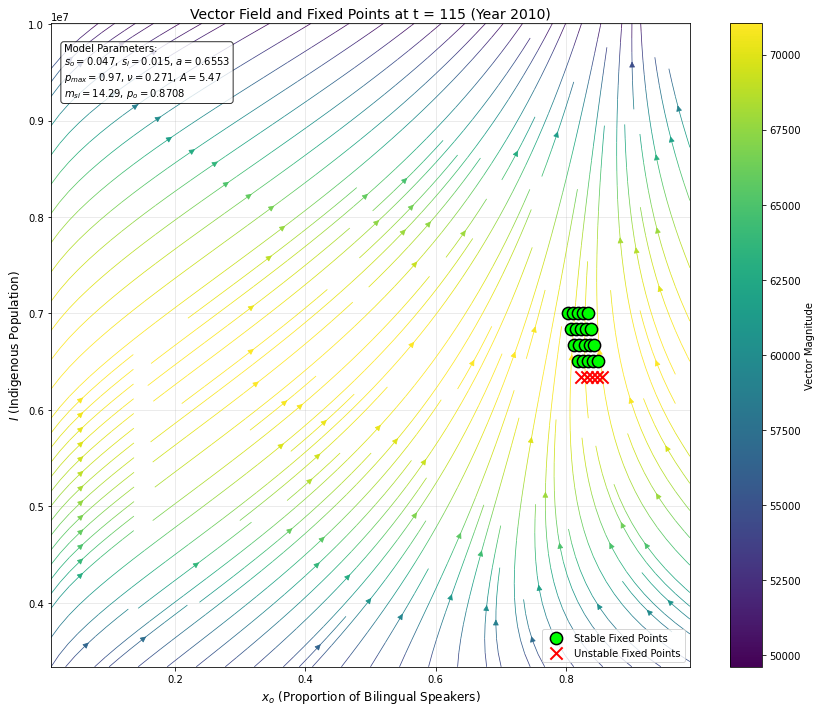

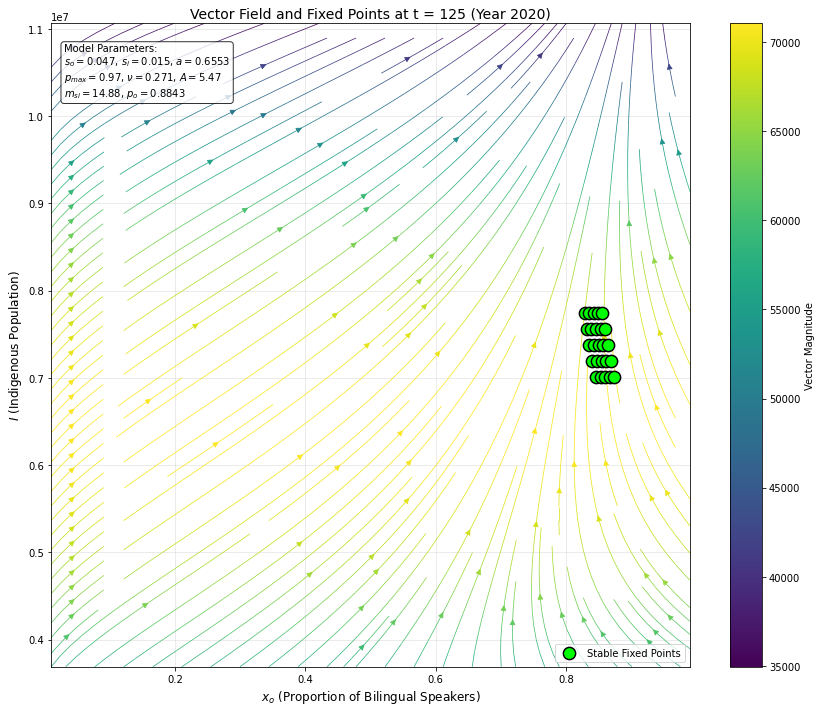

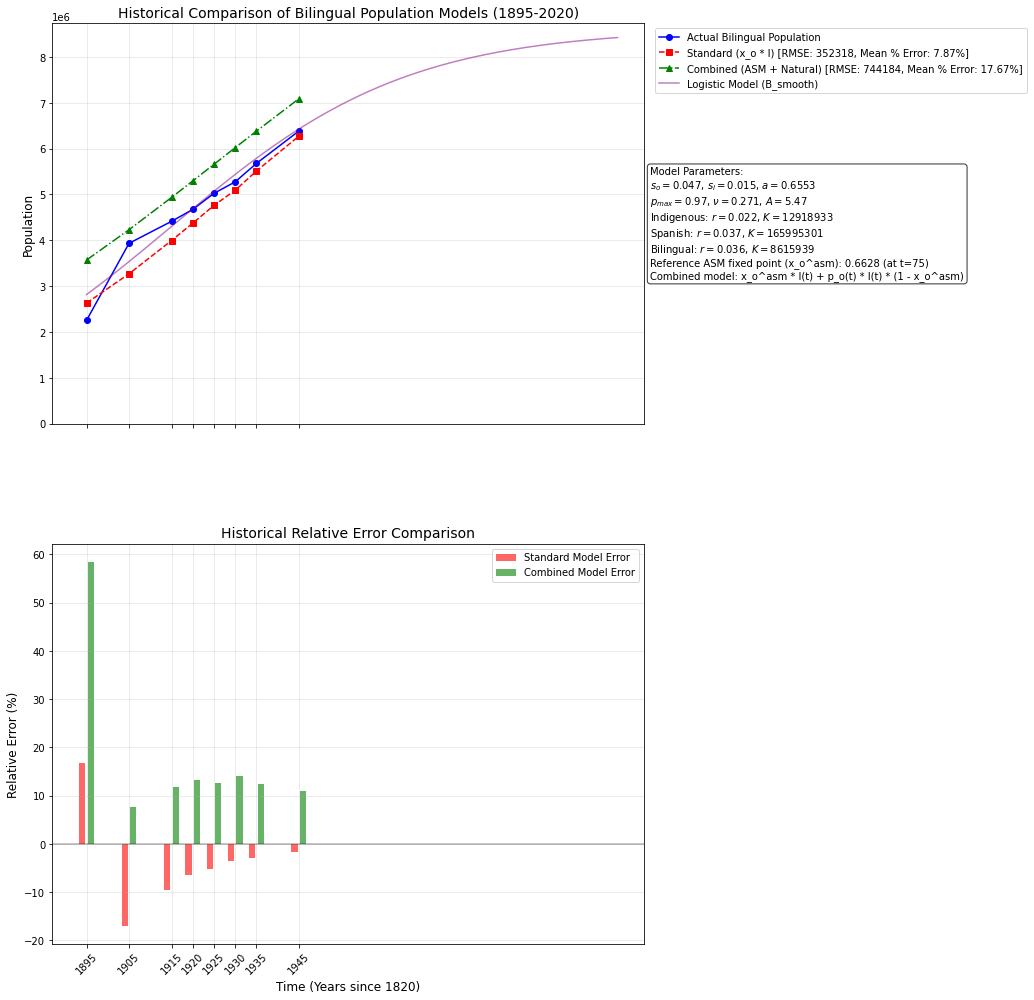

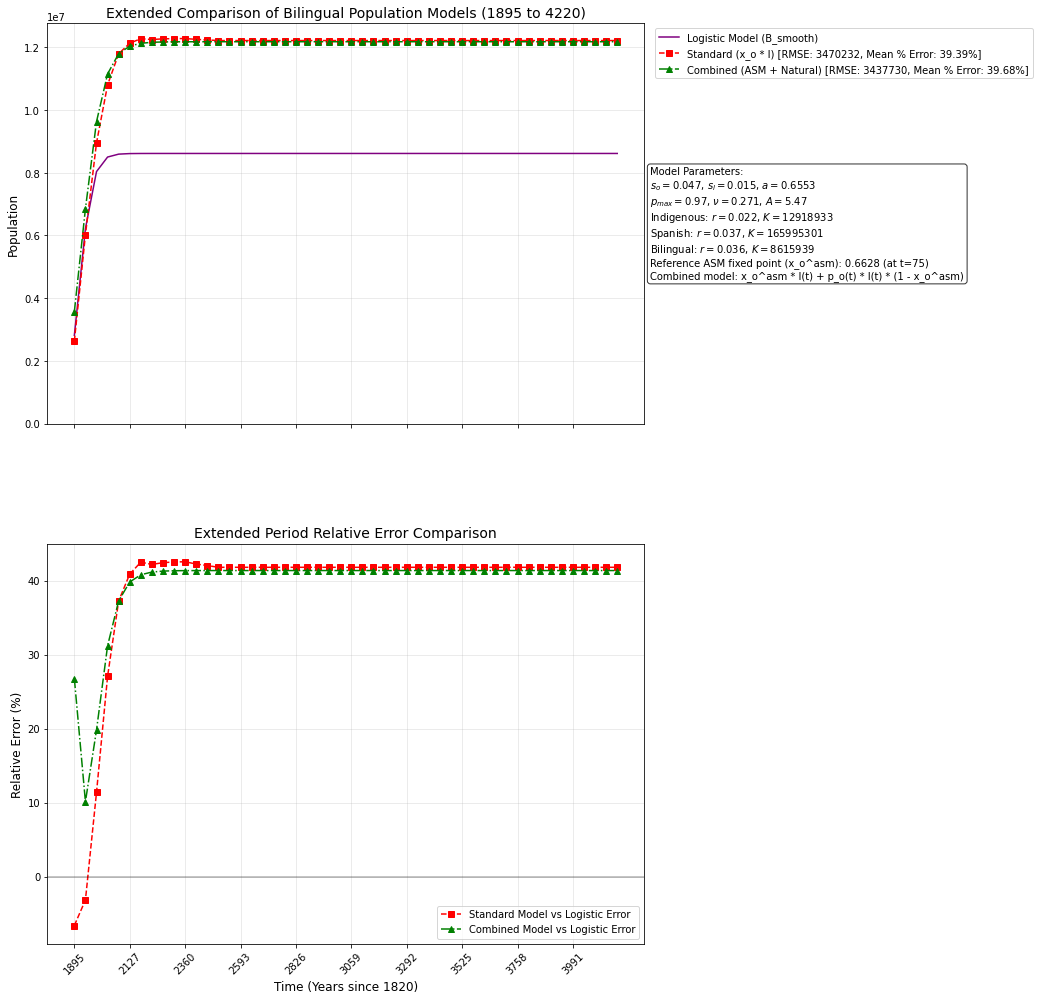

In [4]:
#### FINAL 220325
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.metrics import mean_squared_error
# Data and parameters
data = {
    'Year': [1895, 1900, 1910, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 1995, 2000, 2005, 2010, 2020],
    'Spanish': [3394259.0, 4054539.0, 10907376.0, 11624643.0, 14080954.0, 19272593.0, 25968301.0, 36946313.0, 51353211.0, 64104668.0, 74378670.0, 78381411.0, 83704299.0, 93203961.0, 108408500.0],
    'Indigenous': [1030670.0, 1144766.0, 1619825.0, 2370324.0, 2490909.0, 2447615.0, 3030254.0, 3111415.0, 5181038.0, 5282347.0, 5483555.0, 6044547.0, 6011202.0, 6695228.0, 7177185.0],
    'Bilingual': [297977.0, 337528.0, 478232.0, 1126925.0, 1253891.0, 1652544.0, 1925299.0, 2251561.0, 3932514.0, 4411818.0, 4671553.0, 5022373.0, 5274418.0, 5676791.0, 6383553.0]
}
df = pd.DataFrame(data)

# Convert years to time points starting from 0 (1895 = 0)
base_year = 1895
df['t'] = df['Year'] - base_year

# Parameters for logistic functions
# For Bilingual
N0_bilingual = 272030  # Initial value
K_bilingual = 8615939  # Carrying capacity
r_bilingual = 0.036    # Growth rate

# For Indigenous
N0_indigenous = 1012848  # Initial value
K_indigenous = 12918933  # Carrying capacity
r_indigenous = 0.022     # Growth rate

# For Spanish
N0_spanish = 3117878    # Initial value
K_spanish = 165995301   # Carrying capacity
r_spanish = 0.037       # Growth rate

# Parameters for p_o function
A = 5.47
nu = 0.271
p_max = 0.97

# Parameters for dynamics f function
s_o = 0.0349  # Status of Bilingual language
s_l = 0.0055  # Status of Indigenous language
a = 1.252    # Preference parameter


# Parameters for dynamics f function
s_o = 0.047  # Status of Bilingual language (adjust as needed)
s_l = 0.015  # Status of Indigenous language (adjust as needed)
a = 0.6553     # Preference parameter (adjust as needed)
# Parameters to extract points of I and S around t_fixed
"""
# Parameters for dynamics f function
s_o = 0.0454  # Status of Bilingual language
s_l = 0.00838  # Status of Indigenous language
a = 1.4778    # Preference parameter
"""
delta_factor = 0.05  # 5%
num_points = 5  # five points

# Create time points for smooth curves
t_smooth = np.linspace(0, 2020-base_year, 500)

def logistic_function(t, K, r, N0):
    """
    Logistic growth function
    
    Parameters:
    t (array-like): Time points
    K (float): Carrying capacity
    r (float): Growth rate
    N0 (float): Initial value
    
    Returns:
    array-like: Population values at time t
    """
    return K / (1 + ((K - N0) / N0) * np.exp(-r * t))

def m_si(t=None, S=None, I=None):
    """
    Calculate the ratio of Spanish speakers to Indigenous speakers
    
    Parameters:
    t (float or array, optional): Time points
    S (float or array, optional): Number of Spanish speakers. If None, calculated from logistic function
    I (float or array, optional): Number of Indigenous speakers. If None, calculated from logistic function
    
    Returns:
    float or array: Ratio S/I
    """
    if S is None and t is not None:
        S = logistic_function(t, K_spanish, r_spanish, N0_spanish)
    if I is None and t is not None:
        I = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
    
    # Avoid division by zero
    if np.isscalar(I):
        return S / I if I > 0 else np.inf
    else:
        return np.where(I > 0, S / I, np.inf)

def p_o(m, p_max=p_max, A=A, nu=nu):
    """
    Calculate p_o given m_si
    
    Parameters:
    m (float or array): m_si ratio
    p_max (float): Maximum value for p_o
    A (float): Scaling parameter
    nu (float): Growth parameter
    
    Returns:
    float or array: p_o value(s)
    """
    return p_max / (1 + A * np.exp(-nu * m))

def f(x_o, s_o=s_o, s_l=s_l, a=a):
    """
    Standard dynamics term f(x_o)
    
    Parameters:
    x_o (float): Proportion of bilingual speakers
    s_o (float): Status of bilingual language
    s_l (float): Status of indigenous language
    a (float): Preference parameter
    
    Returns:
    float: Dynamics value
    """
    return s_o * (x_o**a) * (1 - x_o) - s_l * ((1 - x_o)**a) * x_o

def g(x_o, p_o, m, I):
    """
    Dynamics for natural increments
    
    Parameters:
    x_o (float): Proportion of bilingual speakers
    p_o (float): Probability parameter
    m (float): m_si ratio
    I (float): Indigenous population
    
    Returns:
    float: g function value
    """
    term_1 = p_o - x_o - p_o * (1 - p_o/p_max) * nu * m
    term_2 = r_indigenous * (1 - I/K_indigenous)
    return term_1 * term_2

def find_fixed_points(t):
    """
    Find fixed points in the system at time t
    
    Parameters:
    t (float): Time point
    
    Returns:
    list: List of fixed points (x_o, I, S, p)
    """
    fixed_points = []
    
    # Compute I(t) and S(t) from logistic function
    I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
    S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
    
    # Define ranges around I_t and S_t
    delta_I = delta_factor * I_t
    delta_S = delta_factor * S_t
    I_values = np.linspace(I_t - delta_I, I_t + delta_I, num_points)
    S_values = np.linspace(S_t - delta_S, S_t + delta_S, num_points)
    
    for i, I in enumerate(I_values):
        if I <= 0:  # Skip non-positive values
            continue
            
        for j, S in enumerate(S_values):
            m = m_si(None, S, I)
            p = p_o(m)
            
            # Define equation for fixed point
            def fixed_point_eq(x_o):
                return f(x_o) + g(x_o, p, m, I)
            
            # Try multiple initial guesses - IMPROVED to search near both 0 and 1
            initial_guesses = [0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
            for guess in initial_guesses:
                try:
                    sol = fsolve(fixed_point_eq, guess, full_output=True)
                    if sol[2] == 1:  # Check if fsolve converged
                        x_o = sol[0][0]
                        if 0 <= x_o <= 1:  # Check if solution is in valid range
                            fixed_points.append((x_o, I, S, p))
                except Exception as e:
                    print(f"Error in fsolve: {e}")
                    continue
    
    # Remove duplicates (with some tolerance)
    unique_points = []
    for point in fixed_points:
        is_duplicate = False
        for unique in unique_points:
            if np.abs(point[0] - unique[0]) < 1e-6 and np.abs(point[1] - unique[1]) < 1e-6:
                is_duplicate = True
                break
        if not is_duplicate:
            unique_points.append(point)
            
    return unique_points

def calculate_jacobian(x_o, I, S, p):
    """
    Calculate the Jacobian matrix at a fixed point - CORRECTED formulas for ASM model
    
    Parameters:
    x_o (float): Fixed point x_o value
    I (float): Fixed point I value
    S (float): S value at fixed point
    p (float): p value at fixed point
    
    Returns:
    numpy.ndarray: 2x2 Jacobian matrix
    """
    try:
        # Safe computations for powers
        def safe_pow(base, exponent):
            if base < 0 and not exponent.is_integer():
                return 0  # Avoid complex numbers
            if base == 0 and exponent < 0:
                return 0  # Avoid division by zero
            return base ** exponent
        
        # J_00 calculation - derivative of dx_o/dt with respect to x_o
        # Term from f(x_o)
        term1 = s_o * a * safe_pow(x_o, a-1) * (1-x_o) - s_o * safe_pow(x_o, a)
        term2 = -s_l * a * safe_pow(1-x_o, a-1) * x_o - s_l * safe_pow(1-x_o, a)
        
        # Term from g(x_o)
        term3 = -r_indigenous * (1 - I/K_indigenous)
        
        J_00 = term1 + term2 + term3
        
        # J_10 - derivative of dI/dt with respect to x_o
        J_10 = 0  # x_o doesn't affect I directly
        
        # J_01 - derivative of dx_o/dt with respect to I
        m = m_si(None, S, I)
        
        # Term from g(x_o)
        term4 = (p - x_o - p * (1 - p/p_max) * nu * m) * (-r_indigenous/K_indigenous)
        term5 = p * (1 - p/p_max) * nu * (-S/I**2) * r_indigenous * (1 - I/K_indigenous)
        
        J_01 = term4 + term5
        
        # J_11 - derivative of dI/dt with respect to I
        J_11 = r_indigenous * (1 - 2*I/K_indigenous)
        
        return np.array([[J_00, J_01], [J_10, J_11]])
    except Exception as e:
        print(f"Error calculating Jacobian: {e}")
        # Return a default Jacobian
        return np.array([[0.0, 0.0], [0.0, 0.0]])

def analyze_stability(fixed_points):
    """
    Analyze the stability of fixed points
    
    Parameters:
    fixed_points (list): List of fixed points (x_o, I, S, p)
    
    Returns:
    list: List of fixed points with stability information
    """
    results = []
    for x_o, I, S, p in fixed_points:
        try:
            J = calculate_jacobian(x_o, I, S, p)
            eigenvalues = np.linalg.eigvals(J)
            stable = all(np.real(eigenvalues) < 0)
            results.append((x_o, I, S, p, stable, eigenvalues))
        except Exception as e:
            print(f"Error in stability analysis: {e}")
            # Mark as unstable by default
            results.append((x_o, I, S, p, False, np.array([1.0, 1.0])))
    
    return results

def system(t, state, S, p):
    """
    System of differential equations
    
    Parameters:
    t (float): Time
    state (list): [x_o, I]
    S (float): Spanish speakers
    p (float): Probability parameter
    
    Returns:
    list: [dx_o/dt, dI/dt]
    """
    x_o, I = state
    
    if I <= 0:  # Avoid division by zero
        return [0, 0]
    
    m = m_si(None, S, I)
    
    # dx_o/dt calculation
    term_1 = f(x_o)  # Standard dynamics
    term_2 = g(x_o, p, m, I)  # Natural increments
    dx_o_dt = term_1 + term_2
    
    # dI/dt calculation
    dI_dt = r_indigenous * I * (1 - (I/K_indigenous))
    
    return [dx_o_dt, dI_dt]

def plot_vector_field(t, x_range, I_range, S, p, fixed_points_with_stability):
    """
    Plot vector field and fixed points - IMPROVED visualization
    
    Parameters:
    t (float): Time
    x_range (array): Range of x_o values
    I_range (array): Range of I values
    S (float): Spanish speakers at time t
    p (float): Probability parameter at time t
    fixed_points_with_stability (list): Fixed points with stability information
    
    Returns:
    matplotlib.figure.Figure: Figure object
    """
    X, I = np.meshgrid(x_range, I_range)
    U = np.zeros(X.shape)
    V = np.zeros(X.shape)
    
    # Calculate derivatives at each grid point
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if I[i, j] > 0:
                derivatives = system(t, [X[i, j], I[i, j]], S, p)
                U[i, j], V[i, j] = derivatives

    # Compute magnitude for color mapping
    magnitude = np.sqrt(U**2 + V**2)
    # Avoid division by zero in normalization
    max_mag = np.percentile(magnitude[magnitude > 0], 95) if np.any(magnitude > 0) else 1.0
    U_norm = np.where(magnitude > 0, U / max_mag, 0)
    V_norm = np.where(magnitude > 0, V / max_mag, 0)

    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Use streamplot with normalized vectors
    stream = ax.streamplot(X, I, U_norm, V_norm, density=1.5, color=magnitude, 
                           cmap='viridis', linewidth=0.75, arrowsize=1.2)

    # Plot fixed points with larger markers
    stable_points = [(x, I) for x, I, _, _, stable, _ in fixed_points_with_stability if stable]
    unstable_points = [(x, I) for x, I, _, _, stable, _ in fixed_points_with_stability if not stable]

    if stable_points:
        stable_x, stable_I = zip(*stable_points)
        ax.scatter(stable_x, stable_I, color='lime', s=150, marker='o', 
                  edgecolor='black', linewidth=1.5, label='Stable Fixed Points', zorder=3)

    if unstable_points:
        unstable_x, unstable_I = zip(*unstable_points)
        ax.scatter(unstable_x, unstable_I, color='red', s=150, marker='x', 
                  linewidth=2, label='Unstable Fixed Points', zorder=3)

    # Add additional information to the plot
    ax.set_xlabel('$x_o$ (Proportion of Bilingual Speakers)', fontsize=12)
    ax.set_ylabel('$I$ (Indigenous Population)', fontsize=12)
    ax.set_title(f'Vector Field and Fixed Points at t = {t} (Year {base_year + t})', fontsize=14)
    
    # Display model parameters
    params_text = (
        f"Model Parameters:\n"
        f"$s_o = {s_o}$, $s_l = {s_l}$, $a = {a}$\n"
        f"$p_{{max}} = {p_max}$, $\\nu = {nu}$, $A = {A}$\n"
        f"$m_{{si}} = {m_si(None, S, I_range.mean()):.2f}$, $p_o = {p:.4f}$"
    )
    ax.text(0.02, 0.97, params_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(min(x_range), max(x_range))
    ax.set_ylim(min(I_range), max(I_range))
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=10)

    # Correct colorbar handling
    norm = colors.Normalize(vmin=magnitude.min(), vmax=magnitude.max())
    sm = cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Required for colorbar
    cbar = fig.colorbar(sm, ax=ax, label='Vector Magnitude')

    plt.tight_layout()
    return fig

def analyze_system(time_points):
    """
    Analyze system dynamics at specified time points
    
    Parameters:
    time_points (list): List of time points to analyze
    
    Returns:
    dict: Dictionary of results for each time point
    """
    all_results = {}
    
    for t in time_points:
        print(f"\nAnalyzing at time t = {t} (Year {base_year + t})")
        
        # Calculate the expected values of I and S at time t
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        m_t = m_si(None, S_t, I_t)
        p_t = p_o(m_t)
        
        print(f"Expected values at t = {t}:")
        print(f"  I(t) = {I_t:.2f}, S(t) = {S_t:.2f}")
        print(f"  m_si = {m_t:.2f}, p_o = {p_t:.4f}")
        
        # Find fixed points
        fixed_points = find_fixed_points(t)
        print(f"Found {len(fixed_points)} fixed point(s) at t = {t}")
        
        # Analyze stability
        stability_results = analyze_stability(fixed_points)
        
        # Print fixed points and stability
        x_o_list=[]
        eigen_list=[]
        
        for i, (x_o, I, S, p, stable, eigenvalues) in enumerate(stability_results):
            stability = "Stable" if stable else "Unstable"
            print(f"  Fixed Point {i+1}: (x_o = {x_o:.4f}, I = {I:.4f}) - {stability}")
            print(f"    S = {S:.0f}, p = {p:.4f}")
            print(f"    Eigenvalues: {eigenvalues}")
            x_o_list.append(x_o)
            eigen_list.append(eigenvalues[0])
        

        # Mean x_o for stable vs unstable fixed points
        stable_x_o = [x_o for x_o, _, _, _, stable, _ in stability_results if stable]
        unstable_x_o = [x_o for x_o, _, _, _, stable, _ in stability_results if not stable]
        
        if stable_x_o:
            mean_stable_x_o = np.mean(stable_x_o)
            print(f"Mean x_o for stable fixed points: {mean_stable_x_o:.4f}")
        
        if unstable_x_o:
            mean_unstable_x_o = np.mean(unstable_x_o)
            print(f"Mean x_o for unstable fixed points: {mean_unstable_x_o:.4f}")
        # Option 3: Mean of dominant eigenvalues (the one with largest real part from each fixed point)
        dominant_eigenvalues = []
        for _, _, _, _, _, eigenvalues in stability_results:
            # Find eigenvalue with largest real part
            dominant = max(eigenvalues, key=lambda x: np.real(x))
            dominant_eigenvalues.append(dominant)
        mean_dominant = np.mean(dominant_eigenvalues)
        print(f"Mean of the dominant eigenvalue: {mean_dominant:.4f}")

        dominant_eigenvalues = []
        for _, _, _, _, _, eigenvalues in stability_results:
            # Find eigenvalue with largest magnitude (absolute value)
            dominant = max(eigenvalues, key=lambda x: abs(x))
            dominant_eigenvalues.append(dominant)
        mean_dominant_magnitude = np.mean([abs(eig) for eig in dominant_eigenvalues])
        print(f"Mean of the dominant ABS eigenvalue: {mean_dominant_magnitude:.4f}")
        x_range = np.linspace(0.01, 0.99, 30)
        
        # Use a reasonable range around the expected I_t
        I_min = max(0.1, I_t * 0.5)
        I_max = I_t * 1.5
        I_range = np.linspace(I_min, I_max, 30)
        
        # Create vector field plot using expected trajectory values
        fig = plot_vector_field(t, x_range, I_range, S_t, p_t, stability_results)
        
        all_results[t] = {
            'fixed_points': fixed_points,
            'stability': stability_results,
            'figure': fig,
            'I_t': I_t,
            'S_t': S_t,
            'm_t': m_t,
            'p_t': p_t
        }
    
    return all_results
# EXTENDED
def calculate_bilingual_error(time_points, t_start=75, t_end=2400, historical_end=2020):
    """
    Calculate and plot error comparing different Bilingual population models:
    1. Actual bilingual data vs predictions (historical period: 1895-2020)
    2. Logistic curve model vs predictions (extended period: t_start to t_end)
    
    Parameters:
    time_points (list): List of time points to analyze
    t_start (float): Starting time point for analysis
    t_end (float): Ending time point for full analysis
    historical_end (int): End year for historical comparison (default: 2020)
    
    Returns:
    tuple: (fig1, fig2) Two figures with error plots
    """
    base_year = 1820  # Assuming this is defined elsewhere
    
    # PART 1: HISTORICAL COMPARISON (1895-2020)
    # Filter data for historical period
    historical_t_start = 75  # 1895 (assuming base_year is 1820)
    historical_t_end = historical_end - base_year
    historical_df = df[(df['t'] >= historical_t_start) & (df['t'] <= historical_t_end)].copy()
    
    # Use actual data points for historical period
    actual_bilingual = historical_df['Bilingual'].values
    actual_time = historical_df['t'].values
    
    # Storage for different model predictions for historical period
    historical_standard_bilingual = []  # x_o * I (from ASM fixed points)
    historical_combined_bilingual = []  # x_o^asm * I(t) + p_o(t) * I(t) (for fixed ASM point)
    
    # Get the ASM fixed point at the earliest time point (as reference)
    t_ref = actual_time[0]
    I_ref = logistic_function(t_ref, K_indigenous, r_indigenous, N0_indigenous)
    S_ref = logistic_function(t_ref, K_spanish, r_spanish, N0_spanish)
    fixed_points_ref = find_fixed_points(t_ref)
    stability_results_ref = analyze_stability(fixed_points_ref)
    
    # Get reference x_o^asm from stable fixed points
    asm_fixed_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results_ref if stable]
    
    if asm_fixed_points:
        x_o_asm = np.mean([x for x, _ in asm_fixed_points])
    else:
        # If no stable fixed points, use the first unstable one
        unstable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results_ref if not stable]
        if unstable_points:
            x_o_asm = np.mean([x for x, _ in unstable_points])
        else:
            # No fixed points found
            x_o_asm = 0.5  # Default value
    
    print(f"Reference ASM fixed point (x_o^asm) at t={t_ref}: {x_o_asm:.4f}")
    
    # Calculate model predictions for each historical time point
    for t in actual_time:
        # Calculate the expected values at time t
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        m_t = m_si(None, S_t, I_t)
        p_t = p_o(m_t)
        
        # Find fixed points at current time
        fixed_points = find_fixed_points(t)
        stability_results = analyze_stability(fixed_points)
        
        # Get standard model prediction (x_o * I from current fixed points)
        stable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if stable]
        
        if stable_points:
            # Use mean x_o from stable fixed points
            mean_x_o = np.mean([x for x, _ in stable_points])
            historical_standard_bilingual.append(mean_x_o * I_t)
        else:
            # If no stable fixed points, use the first unstable one
            unstable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if not stable]
            if unstable_points:
                mean_x_o = np.mean([x for x, _ in unstable_points])
                historical_standard_bilingual.append(mean_x_o * I_t)
            else:
                # No fixed points found
                historical_standard_bilingual.append(np.nan)
        
        # Calculate combined model prediction (fixed ASM + natural increment)
        # x_o^asm * I(t) + p_o(t) * I(t)
        combined_pred = x_o_asm * I_t + p_t * I_t * (1 - x_o_asm)
        historical_combined_bilingual.append(combined_pred)
    
    # Calculate errors for historical standard model
    historical_standard_error = np.array(historical_standard_bilingual) - actual_bilingual
    historical_standard_relative_error = historical_standard_error / actual_bilingual * 100
    historical_standard_rmse = np.sqrt(np.nanmean(historical_standard_error**2))
    historical_standard_mean_pct_error = np.nanmean(abs(historical_standard_relative_error))
    
    # Calculate errors for historical combined model
    historical_combined_error = np.array(historical_combined_bilingual) - actual_bilingual
    historical_combined_relative_error = historical_combined_error / actual_bilingual * 100
    historical_combined_rmse = np.sqrt(np.nanmean(historical_combined_error**2))
    historical_combined_mean_pct_error = np.nanmean(abs(historical_combined_relative_error))
    
    # Create figure 1 for historical comparison
    fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14), sharex=True)
    
    # Plot 1: Compare different historical bilingual population models
    ax1.plot(actual_time, actual_bilingual, 'o-', color='blue', label='Actual Bilingual Population')
    ax1.plot(actual_time, historical_standard_bilingual, 's--', color='red', 
             label=f'Standard (x_o * I) [RMSE: {historical_standard_rmse:.0f}, Mean % Error: {historical_standard_mean_pct_error:.2f}%]')
    ax1.plot(actual_time, historical_combined_bilingual, '^-.', color='green', 
             label=f'Combined (ASM + Natural) [RMSE: {historical_combined_rmse:.0f}, Mean % Error: {historical_combined_mean_pct_error:.2f}%]')
    
    # Create smooth curve for historical period
    historical_t_smooth = np.linspace(historical_t_start, historical_t_end, 500)
    historical_B_smooth = logistic_function(historical_t_smooth, K_bilingual, r_bilingual, N0_bilingual)
    ax1.plot(historical_t_smooth, historical_B_smooth, '-', color='purple', alpha=0.5, label='Logistic Model (B_smooth)')
    
    ax1.set_ylabel('Population', fontsize=12)
    ax1.set_title('Historical Comparison of Bilingual Population Models (1895-2020)', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    ax1.set_ylim(bottom=0)  # Start from 0
    
    # Plot 2: Historical relative errors
    ax2.bar(actual_time - 1, historical_standard_relative_error, width=1.5, color='red', alpha=0.6, label='Standard Model Error')
    ax2.bar(actual_time + 1, historical_combined_relative_error, width=1.5, color='green', alpha=0.6, label='Combined Model Error')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel(f'Time (Years since {base_year})', fontsize=12)
    ax2.set_ylabel('Relative Error (%)', fontsize=12)
    ax2.set_title('Historical Relative Error Comparison', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add years to x-axis for historical plot
    historical_year_labels = [f"{base_year + int(t)}" for t in actual_time]
    ax2.set_xticks(actual_time)
    ax2.set_xticklabels(historical_year_labels, rotation=45)
    
    # Add parameter annotation to historical plot
    params_text = (
        f"Model Parameters:\n"
        f"$s_o = {s_o}$, $s_l = {s_l}$, $a = {a}$\n"
        f"$p_{{max}} = {p_max}$, $\\nu = {nu}$, $A = {A}$\n"
        f"Indigenous: $r = {r_indigenous}$, $K = {K_indigenous:.0f}$\n"
        f"Spanish: $r = {r_spanish}$, $K = {K_spanish:.0f}$\n"
        f"Bilingual: $r = {r_bilingual}$, $K = {K_bilingual:.0f}$\n"
        f"Reference ASM fixed point (x_o^asm): {x_o_asm:.4f} (at t={t_ref})\n"
        f"Combined model: x_o^asm * I(t) + p_o(t) * I(t) * (1 - x_o^asm)"
    )
    ax1.text(1.01, 0.5, params_text, transform=ax1.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig1.subplots_adjust(right=0.75, hspace=0.3)  # Make room for annotations
    
    # PART 2: EXTENDED COMPARISON (t_start to t_end)
    # Create time points for extended smooth curves
    extended_t_smooth = np.linspace(t_start, t_end, 500)
    
    # Calculate expected population curves for extended period
    extended_I_smooth = logistic_function(extended_t_smooth, K_indigenous, r_indigenous, N0_indigenous)
    extended_B_smooth = logistic_function(extended_t_smooth, K_bilingual, r_bilingual, N0_bilingual)
    
    # Calculate model predictions for extended period
    extended_standard_bilingual = []
    extended_combined_bilingual = []
    
    # Create a subset of time points for visualization (to avoid overcrowding)
    step = max(1, len(extended_t_smooth) // 50)  # Use at most 50 points
    selected_extended_times = extended_t_smooth[::step]
    
    for t in selected_extended_times:
        # Calculate expected values at time t
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        m_t = m_si(None, S_t, I_t)
        p_t = p_o(m_t)
        
        # Find fixed points at current time
        fixed_points = find_fixed_points(t)
        stability_results = analyze_stability(fixed_points)
        
        # Get standard model prediction
        stable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if stable]
        
        if stable_points:
            mean_x_o = np.mean([x for x, _ in stable_points])
            extended_standard_bilingual.append(mean_x_o * I_t)
        else:
            unstable_points = [(x_o, I) for x_o, I, _, _, stable, _ in stability_results if not stable]
            if unstable_points:
                mean_x_o = np.mean([x for x, _ in unstable_points])
                extended_standard_bilingual.append(mean_x_o * I_t)
            else:
                extended_standard_bilingual.append(np.nan)
        
        # Calculate combined model prediction
        combined_pred = x_o_asm * I_t + p_t * I_t * (1 - x_o_asm)
        extended_combined_bilingual.append(combined_pred)
    
    # Calculate errors for extended period versus logistic model
    extended_standard_vs_logistic = []
    extended_combined_vs_logistic = []
    logistic_values_at_selected_times = []
    
    for i, t in enumerate(selected_extended_times):
        # Get logistic value at this time
        B_t = logistic_function(t, K_bilingual, r_bilingual, N0_bilingual)
        logistic_values_at_selected_times.append(B_t)
        
        # Calculate errors
        if i < len(extended_standard_bilingual):
            standard_error = extended_standard_bilingual[i] - B_t
            extended_standard_vs_logistic.append(standard_error / B_t * 100 if B_t > 0 else np.nan)
        
        if i < len(extended_combined_bilingual):
            combined_error = extended_combined_bilingual[i] - B_t
            extended_combined_vs_logistic.append(combined_error / B_t * 100 if B_t > 0 else np.nan)
    
    # Calculate RMSE and mean percentage error for extended period
    extended_standard_rmse = np.sqrt(np.nanmean(np.array([(extended_standard_bilingual[i] - logistic_values_at_selected_times[i])**2 
                                                         for i in range(len(extended_standard_bilingual))])))
    extended_combined_rmse = np.sqrt(np.nanmean(np.array([(extended_combined_bilingual[i] - logistic_values_at_selected_times[i])**2 
                                                         for i in range(len(extended_combined_bilingual))])))
    
    extended_standard_mean_pct_error = np.nanmean(abs(np.array(extended_standard_vs_logistic)))
    extended_combined_mean_pct_error = np.nanmean(abs(np.array(extended_combined_vs_logistic)))
    
    # Create figure 2 for extended comparison
    fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 14), sharex=True)
    
    # Plot 3: Extended period comparison with logistic model
    ax3.plot(selected_extended_times, logistic_values_at_selected_times, '-', color='purple', 
             label='Logistic Model (B_smooth)')
    ax3.plot(selected_extended_times, extended_standard_bilingual, 's--', color='red', 
             label=f'Standard (x_o * I) [RMSE: {extended_standard_rmse:.0f}, Mean % Error: {extended_standard_mean_pct_error:.2f}%]')
    ax3.plot(selected_extended_times, extended_combined_bilingual, '^-.', color='green', 
             label=f'Combined (ASM + Natural) [RMSE: {extended_combined_rmse:.0f}, Mean % Error: {extended_combined_mean_pct_error:.2f}%]')
    
    ax3.set_ylabel('Population', fontsize=12)
    ax3.set_title(f'Extended Comparison of Bilingual Population Models ({base_year+t_start} to {base_year+t_end})', fontsize=14)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    ax3.set_ylim(bottom=0)  # Start from 0
    
    # Plot 4: Extended period relative errors
    ax4.plot(selected_extended_times, extended_standard_vs_logistic, 's--', color='red', 
             label='Standard Model vs Logistic Error')
    ax4.plot(selected_extended_times, extended_combined_vs_logistic, '^-.', color='green', 
             label='Combined Model vs Logistic Error')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.set_xlabel(f'Time (Years since {base_year})', fontsize=12)
    ax4.set_ylabel('Relative Error (%)', fontsize=12)
    ax4.set_title('Extended Period Relative Error Comparison', fontsize=14)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # Add years to x-axis for extended plot (but not too many)
    extended_tick_step = max(1, len(selected_extended_times) // 10)  # At most 10 ticks
    extended_ticks = selected_extended_times[::extended_tick_step]
    extended_year_labels = [f"{base_year + int(t)}" for t in extended_ticks]
    ax4.set_xticks(extended_ticks)
    ax4.set_xticklabels(extended_year_labels, rotation=45)
    
    # Add parameter annotation to extended plot
    ax3.text(1.01, 0.5, params_text, transform=ax3.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig2.subplots_adjust(right=0.75, hspace=0.3)  # Make room for annotations
    
    return fig1, fig2

def long_term_analysis(start_year=2000, end_year=4000, step=50):
    """
    Analyze system dynamics over an extended time period
    
    Parameters:
    start_year (int): Starting year for analysis
    end_year (int): Ending year for analysis
    step (int): Step size in years
    
    Returns:
    matplotlib.figure.Figure: Figure with long-term trends
    """
    # Convert years to time points
    start_t = start_year - base_year
    end_t = end_year - base_year
    
    # Create time points
    time_points = np.arange(start_t, end_t + 1, step)
    years = [base_year + t for t in time_points]
    
    # Data structures to store results
    stable_x_means = []
    unstable_x_means = []
    dominant_eigenvalues_real = []
    dominant_eigenvalues_abs = []
    indigenous_pop = []
    spanish_pop = []
    msi_values = []
    po_values = []
    
    # To detect stabilization
    stable_x_diffs = []
    stabilization_detected = False
    stabilization_year = None
    stabilization_idx = None
    stabilization_threshold = 0.0001  # Threshold for considering variation negligible
    window_size = 5  # How many consecutive points to check for stabilization
    
    for t in time_points:
        print(f"Long-term analysis at t = {t} (Year {base_year + t})")
        
        # Calculate the expected values at time t
        I_t = logistic_function(t, K_indigenous, r_indigenous, N0_indigenous)
        S_t = logistic_function(t, K_spanish, r_spanish, N0_spanish)
        m_t = m_si(None, S_t, I_t)
        p_t = p_o(m_t)
        
        indigenous_pop.append(I_t)
        spanish_pop.append(S_t)
        msi_values.append(m_t)
        po_values.append(p_t)
        
        # Find fixed points
        fixed_points = find_fixed_points(t)
        stability_results = analyze_stability(fixed_points)
        
        # Extract stable and unstable points
        stable_x_o = [x_o for x_o, _, _, _, stable, _ in stability_results if stable]
        unstable_x_o = [x_o for x_o, _, _, _, stable, _ in stability_results if not stable]
        
        # Calculate means
        if stable_x_o:
            stable_x_means.append(np.mean(stable_x_o))
        else:
            stable_x_means.append(np.nan)
        
        if unstable_x_o:
            unstable_x_means.append(np.mean(unstable_x_o))
        else:
            unstable_x_means.append(np.nan)
        
        # Calculate mean of dominant eigenvalues
        dominant_real = []
        dominant_abs = []
        
        for _, _, _, _, _, eigenvalues in stability_results:
            # Find eigenvalue with largest real part
            if len(eigenvalues) > 0:
                dominant_real.append(max(eigenvalues, key=lambda x: np.real(x)))
                dominant_abs.append(max(eigenvalues, key=lambda x: abs(x)))
        
        if dominant_real:
            dominant_eigenvalues_real.append(np.mean([np.real(eig) for eig in dominant_real]))
        else:
            dominant_eigenvalues_real.append(np.nan)
            
        if dominant_abs:
            dominant_eigenvalues_abs.append(np.mean([abs(eig) for eig in dominant_abs]))
        else:
            dominant_eigenvalues_abs.append(np.nan)
            
        # Calculate variation in stable fixed points
        if len(stable_x_means) > 1:
            stable_x_diff = abs(stable_x_means[-1] - stable_x_means[-2])
            stable_x_diffs.append(stable_x_diff)
            
            # Check for stabilization
            if len(stable_x_diffs) >= window_size and not stabilization_detected:
                recent_diffs = stable_x_diffs[-window_size:]
                if all(diff < stabilization_threshold for diff in recent_diffs):
                    stabilization_detected = True
                    stabilization_idx = len(stable_x_means) - window_size
                    stabilization_year = years[stabilization_idx]
                    print(f"Stabilization detected at year {stabilization_year}")
    
    # Get stabilized values for legend if stabilization was detected
    if stabilization_detected:
        stab_stable_x = stable_x_means[stabilization_idx]
        stab_unstable_x = unstable_x_means[stabilization_idx]
        stab_eigen_real = dominant_eigenvalues_real[stabilization_idx]
        stab_eigen_abs = dominant_eigenvalues_abs[stabilization_idx]
        stab_indigenous = indigenous_pop[stabilization_idx]
        stab_spanish = spanish_pop[stabilization_idx]
        stab_msi = msi_values[stabilization_idx]
        stab_po = po_values[stabilization_idx]
    
    # Create figure for long-term trends
    fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)
    
    # Plot mean of stable and unstable fixed points
    ax1 = axes[0]
    if stabilization_detected:
        ax1.plot(years, stable_x_means, 'o-', color='green', 
                 label=f'Mean Stable x_o (Stabilized: {stab_stable_x:.4f})')
        ax1.plot(years, unstable_x_means, 's--', color='red', 
                 label=f'Mean Unstable x_o (Stabilized: {stab_unstable_x:.4f})')
    else:
        ax1.plot(years, stable_x_means, 'o-', color='green', label='Mean Stable x_o')
        ax1.plot(years, unstable_x_means, 's--', color='red', label='Mean Unstable x_o')
    
    ax1.set_ylabel('Mean x_o Value', fontsize=12)
    ax1.set_title('Long-term Trends in Fixed Points', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Plot eigenvalues
    ax2 = axes[1]
    if stabilization_detected:
        ax2.plot(years, dominant_eigenvalues_real, 'o-', color='blue', 
                 label=f'Mean Dominant Eigenvalue (Real Part) (Stabilized: {stab_eigen_real:.4f})')
        ax2.plot(years, dominant_eigenvalues_abs, 's--', color='purple', 
                 label=f'Mean Dominant Eigenvalue (Absolute Value) (Stabilized: {stab_eigen_abs:.4f})')
    else:
        ax2.plot(years, dominant_eigenvalues_real, 'o-', color='blue', 
                 label='Mean Dominant Eigenvalue (Real Part)')
        ax2.plot(years, dominant_eigenvalues_abs, 's--', color='purple', 
                 label='Mean Dominant Eigenvalue (Absolute Value)')
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.set_ylabel('Eigenvalue', fontsize=12)
    ax2.set_title('Long-term Trends in Eigenvalues', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # Plot population and related parameters
    ax3 = axes[2]
    ax3_twin = ax3.twinx()
    
    # Population on left y-axis
    if stabilization_detected:
        line1, = ax3.plot(years, indigenous_pop, 'o-', color='green', 
                          label=f'Indigenous Population (Stabilized: {stab_indigenous:.0f})')
        line2, = ax3.plot(years, spanish_pop, 's-', color='red', 
                          label=f'Spanish Population (Stabilized: {stab_spanish:.0f})')
        
        # Parameters on right y-axis
        line3, = ax3_twin.plot(years, msi_values, '^--', color='blue', 
                               label=f'm_si Ratio (Stabilized: {stab_msi:.4f})')
        line4, = ax3_twin.plot(years, po_values, 'D--', color='purple', 
                               label=f'p_o Value (Stabilized: {stab_po:.4f})')
    else:
        line1, = ax3.plot(years, indigenous_pop, 'o-', color='green', label='Indigenous Population')
        line2, = ax3.plot(years, spanish_pop, 's-', color='red', label='Spanish Population')
        
        # Parameters on right y-axis
        line3, = ax3_twin.plot(years, msi_values, '^--', color='blue', label='m_si Ratio')
        line4, = ax3_twin.plot(years, po_values, 'D--', color='purple', label='p_o Value')
    
    ax3.set_ylabel('Population', fontsize=12)
    ax3.set_yscale('log')
    ax3_twin.set_ylabel('Parameter Value', fontsize=12)
    
    # Add vertical line for stabilization
    if stabilization_detected:
        for ax in axes:
            ax.axvline(x=stabilization_year, color='black', linestyle='--', alpha=0.7, 
                       label=f'Stabilization ({stabilization_year})')
            # Add text annotation
            ax.text(stabilization_year, ax.get_ylim()[1]*0.95, f"Stabilization\nYear: {stabilization_year}", 
                    ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    # Place legends outside the plots
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    
    # Combined legend for third plot
    lines = [line1, line2, line3, line4]
    ax3.legend(lines, [l.get_label() for l in lines], loc='upper left', bbox_to_anchor=(1.01, 1))
    
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_title('Long-term Population Trends and Parameters', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # Set sensible x-axis tick intervals
    step_ticks = max(1, len(years) // 10)  # Limit to about 10 tick marks
    plt.xticks(years[::step_ticks], rotation=45)
    
    # Add parameters annotation
    params_text = (
        f"Model Parameters:\n"
        f"$s_o = {s_o}$, $s_l = {s_l}$, $a = {a}$\n"
        f"$p_{{max}} = {p_max}$, $\\nu = {nu}$, $A = {A}$\n"
        f"Indigenous: $r = {r_indigenous}$, $K = {K_indigenous:.0f}$\n"
        f"Spanish: $r = {r_spanish}$, $K = {K_spanish:.0f}$"
    )
    ax1.text(1.01, 0.5, params_text, transform=ax1.transAxes, 
             verticalalignment='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add stabilization statistics
    if stabilization_detected:
        stab_text = (
            f"Stabilization Statistics:\n"
            f"Year: {stabilization_year}\n"
            f"Final Stable x_o: {stab_stable_x:.4f}\n"
            f"Final Unstable x_o: {stab_unstable_x:.4f}\n"
            f"Final Dominant Eigenvalue: {stab_eigen_real:.4f}\n"
            f"Indigenous Population: {stab_indigenous:.0f}\n"
            f"Spanish Population: {stab_spanish:.0f}\n"
            f"m_si Ratio: {stab_msi:.4f}\n"
            f"p_o Value: {stab_po:.4f}"
        )
        ax2.text(1.01, 0.5, stab_text, transform=ax2.transAxes, 
                verticalalignment='center', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.8)  # Make room for annotations
    return fig

def main():
    # Define analysis parameters - years since 1895
    time_points = [75.0, 85.0, 95.0, 105.0, 115.0,118.0]
    #time_points = [780, 800, 820, 850, 900,1000]
    #time_points = [10.0, 40.0, 60.0, 75.0]
    time_points=[115,125]
    
    # Run the analysis
    results = analyze_system(time_points)
    
    # Save figures
    for t, result in results.items():
        result['figure'].savefig(f"vector_field_t{int(t)}.png", dpi=300, bbox_inches='tight')
    
    #EXTENDED
    # IMPROVEMENT 1: Calculate and plot bilingual error
    error_fig = calculate_bilingual_error(time_points,t_start=75)
    error_fig.savefig("bilingual_prediction_error.png", dpi=300, bbox_inches='tight')
    # Calculate and plot improved bilingual error comparison
    
   
    
    # IMPROVEMENT 2: Long-term analysis from 2000 to 4000
    long_term_fig = long_term_analysis(start_year=2000, end_year=4000, step=50)
    long_term_fig.savefig("long_term_analysis.png", dpi=300, bbox_inches='tight')
    
    plt.show()

if __name__ == "__main__":
    main()

